This is to do initial analysis on the results of all of the training I have been doing. 

It is split into parts based on the iteration of models I am using. It is meant to generate some plots
however these are not the final plots and are meant to be more exploratory then final. 

In [2]:
import os, sys, time

from pathlib import Path
import pickle 
import json 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

import PyComplexHeatmap as pch
from PyComplexHeatmap import *

In [3]:
import xgboost as xgb
import shap

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score, precision_recall_curve
from scipy.stats import entropy
from itertools import combinations
from sklearn.metrics import mutual_info_score, confusion_matrix

/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cell_types = ['L23_IT_CTX_Glut','L5_ET_CTX_Glut','L6_IT_CTX_Glut','L6_CT_CTX_Glut','CA3_Glut','CA1-ProS_Glut','DG_Glut','Astro-TE_NN','Oligo_NN','OPC_NN',]

## Functions

In [4]:
def information_gain(labels, preds): 
    start_entropy = entropy(pd.DataFrame(labels).value_counts(), base=2)
    ccf = confusion_matrix(labels, preds)
    conditional_entropy = (entropy(ccf, base=2, axis=0) * (ccf.sum(axis=0) / ccf.sum())).sum()
    return start_entropy - conditional_entropy 

def jaccard_similarity(set_1, set_2): 
    inter = len(set_1.intersection(set_2))
    union = len(set_1.union(set_2))
    return inter / union

In [5]:
def read_json(_ct, _epoch): 
    with open(f'../train_models/xgb_logging/{_ct}.epoch_{_epoch}.json', 'r') as fp: 
        res_dict = json.load(fp)

    y_test_labels = res_dict['y_test_labels']
    y_test_preds = res_dict['y_test_preds']
    y_train_labels = res_dict['y_train_labels']
    y_train_preds = res_dict['y_train_preds']
    cols_to_keep = set(res_dict['cols_to_keep'])
    
    return (y_test_labels, y_test_preds, y_train_labels, y_train_preds, cols_to_keep)    

In [6]:
def jaccard_corr_matrix(samples): 
    n_samples = len(samples)
    corr = np.zeros((n_samples,n_samples), dtype=np.float64)
    for i in range(n_samples): 
        for j in range(n_samples): 
            corr[i][j] = jaccard_similarity(samples[i], samples[j])
    return corr

In [7]:
def generate_rank_corr_matrix(cell_types:list, col:str='rank', num_downsample:int|None = None, filename:str="shap_rank"):
    """
    Separate out Results into their up / down / up
    cell_types - the cell types to do this for
    col - the column to extrac (rank / abs_mean_shap)
    """
    df_down = pd.DataFrame()
    df_non = pd.DataFrame()
    df_up = pd.DataFrame()
    for i, _ct in enumerate(cell_types):
        df_rank = pd.read_csv(f'../train_models/xgb_logging/{_ct}.{filename}.csv', index_col='index')
        
        if num_downsample is not None: 
            samp_rank = pd.DataFrame(df_rank.loc[df_rank[f'rank.down'] < num_downsample, f'{col}.down'])
            samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.non'] < num_downsample, f'{col}.non'], left_on='index', right_on = 'index', how='outer')
            samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.up'] < num_downsample, f'{col}.up'], left_on='index', right_on = 'index', how='outer')
            df_rank = samp_rank.copy()
            del samp_rank
    
        if i == 0: 
            df_down[_ct] = df_rank[f'{col}.down']
            df_non[_ct] = df_rank[f'{col}.non']
            df_up[_ct] = df_rank[f'{col}.up']
        else: 
            df_down = df_down.merge(df_rank[f'{col}.down'], left_on='index', right_on='index', how='outer')
            df_down[_ct] = df_down[f'{col}.down'] 
            df_down = df_down.drop(columns = [f'{col}.down'])
    
            df_non = df_non.merge(df_rank[f'{col}.non'], left_on='index', right_on='index', how='outer')
            df_non[_ct] = df_non[f'{col}.non'] 
            df_non = df_non.drop(columns = [f'{col}.non'])
    
            df_up = df_up.merge(df_rank[f'{col}.up'], left_on='index', right_on='index', how='outer')
            df_up[_ct] = df_up[f'{col}.up'] 
            df_up = df_up.drop(columns = [f'{col}.up'])    
    return (df_down, df_non, df_up)

def generate_mod_corr_matrix(cell_types:list, num_downsample:int|None = None, filename:str='shap_rank'):
    """
    Generate counts for the number of features in each data category in the top num_downsample most important
    feature for each classification category.
    cell_types - the cell types to do this for
    col - the column to extrac (rank / abs_mean_shap)
    """
    df_down = pd.DataFrame()
    df_non = pd.DataFrame()
    df_up = pd.DataFrame()
    for i, _ct in enumerate(cell_types):
        df_rank = pd.read_csv(f'../train_models/xgb_logging/{_ct}.{filename}.csv', index_col='index')
        
        if num_downsample is not None: 
            samp_rank = pd.DataFrame(df_rank.loc[df_rank[f'rank.down'] < num_downsample, f'rank.down'])
            samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.non'] < num_downsample, f'rank.non'], left_on='index', right_on = 'index', how='outer')
            samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.up'] < num_downsample, f'rank.up'], left_on='index', right_on = 'index', how='outer')
            df_rank = samp_rank.copy()
            del samp_rank

        mod_split = [x.split('.')[-1] for x in df_rank.index]
        if i == 0: 
            df_counts = pd.DataFrame(pd.DataFrame(mod_split).value_counts())
            df_counts.columns = [_ct]
        else: 
            df_counts[_ct] = pd.DataFrame(mod_split).value_counts()
    
    return df_counts.fillna(0)

In [8]:
def generate_modality_rankings(cell_type:str, ds:int|None=None, filename:str='shap_rank'):
    df_rank = pd.read_csv(f'../train_models/xgb_logging/{_ct}.{filename}.csv', index_col='index')
    df_rank['modality'] = [idx.split(".")[-1] for idx in df_rank.index]
    df_rank = df_rank.rename(columns = {"abs_mean_shap.down" : "-1", "abs_mean_shap.non": "0", "abs_mean_shap.up" : "1"}).drop(columns = ["rank.down", "rank.non", "rank.up"])
    return df_rank

def min_max_norm(df_rank):
    df_rank['1'] = (df_rank['1'] - df_rank['1'].min()) / (df_rank['1'].max() - df_rank['1'].min())
    df_rank['0'] = (df_rank['0'] - df_rank['0'].min()) / (df_rank['0'].max() - df_rank['0'].min())
    df_rank['-1'] = (df_rank['-1'] - df_rank['-1'].min()) / (df_rank['-1'].max() - df_rank['-1'].min())
    return df_rank

## By Cell Cluster (remove?)

In [8]:
cluster_names = ["CTX_Glut", "Hipo_Glut", "NN"]

In [61]:
for i, j in FEAT_DICT.items(): 
    print(i, len(j))

CTX_Glut 48
Hipo_Glut 40
NN 41


In [68]:
# FEAT_DICT = {}
# for _ct in cluster_names: 
#     df_down, df_non, df_up = generate_rank_corr_matrix([_ct], col='rank', num_downsample=20)
#     features = list(df_down.index.union(df_non.index).union(df_up.index))
#     # print(_ct, len(features))
#     # print(features)
#     FEAT_DICT[_ct] = features
#     # break
# FEAT_DICT

In [54]:
cell_types_and_cluster = cell_types + cluster_names

In [94]:
corrs = []
ds_range = [50, 40, 30, 20, 10] 
for ds in ds_range: 
    df_mod = generate_mod_corr_matrix(cell_types_and_cluster, num_downsample=ds)
    df_tt = pd.DataFrame(df_mod.corr()['CTX_Glut'])
    df_tt[ds] = df_tt['CTX_Glut']
    corrs.append(df_tt.drop(columns = ['CTX_Glut']))
    # break

df_ctx_corrs = pd.concat(corrs, axis=1)

In [126]:
df_ctx_corrs = df_ctx_corrs.drop(index=cluster_names)

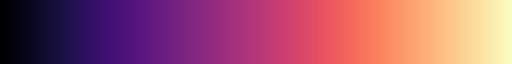

In [114]:
plt.colormaps['magma']

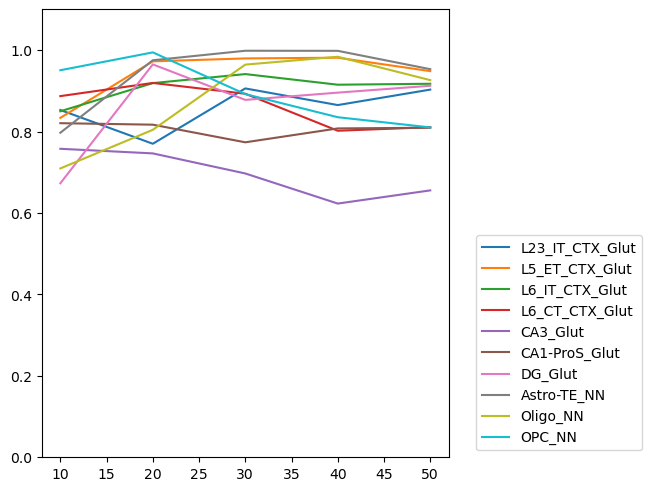

In [138]:
col_scheme = plt.colormaps['tab10']
fig, ax = plt.subplots(1, 1, constrained_layout=True)
for i, row in enumerate(df_ctx_corrs.iterrows()): 
    ct = row[0]
    corr = row[1]
    ax.plot(ds_range, corr, label=ct, c=col_scheme(i))

ax.set_ylim((0, 1.1))

ax.legend(loc='lower left', bbox_to_anchor =(1.05, 0))
plt.show()

In [71]:
df_mod.corr()['CTX_Glut']

L23_IT_CTX_Glut    0.852776
L5_ET_CTX_Glut     0.833494
L6_IT_CTX_Glut     0.849677
L6_CT_CTX_Glut     0.886887
CA3_Glut           0.757554
CA1-ProS_Glut      0.820413
DG_Glut            0.672838
Astro-TE_NN        0.796971
Oligo_NN           0.709362
OPC_NN             0.950478
CTX_Glut           1.000000
Hipo_Glut          0.813373
NN                 0.774839
Name: CTX_Glut, dtype: float64

## Feature Downsampling (remove?)

In [33]:
def generate_ct_features(_ct:str, num_downsample:int|None = None, filename:str = "shap_rank"): 

    df_rank = pd.read_csv(f'../train_models/xgb_logging/{_ct}.{filename}.csv', index_col='index')
    
    if num_downsample is not None: 
        samp_rank = pd.DataFrame(df_rank.loc[df_rank[f'rank.down'] < num_downsample, f'rank.down'])
        samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.non'] < num_downsample, f'rank.non'], left_on='index', right_on = 'index', how='outer')
        samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.up'] < num_downsample, f'rank.up'], left_on='index', right_on = 'index', how='outer')
        df_rank = samp_rank.copy()
        del samp_rank

    features = df_rank.index

    DATA_FEATURE_NAMES = {'meta' : [],'enhancer_DMR' : [],'enhancer_peak' : [],
                          'DAR' : [], 'DMR' : [],'loops' : [],'mcg_genebody' : [], 
                          'mch_genebody' : [], 'atac' : []}
            
    for _feat in features: 
        split_feat = _feat.split(".")
        DATA_FEATURE_NAMES[split_feat[-1]].append(".".join(split_feat[:-1]))
    return DATA_FEATURE_NAMES

In [66]:
DFN_DICT = {}
for _ct in cell_types: 
    DFN = generate_ct_features(_ct, num_downsample=50, filename=filename)
    DFN_DICT[_ct] = DFN

In [69]:
# DFN_DICT

In [68]:
with open('../train_models/xgb_logging/DFN_DICT_CellTypes.pkl', 'wb') as f: 
    pickle.dump(DFN_DICT, f)

# One Off Training Analysis

## One v. Rest

In [139]:
filename="shap_rank_bal.v3"

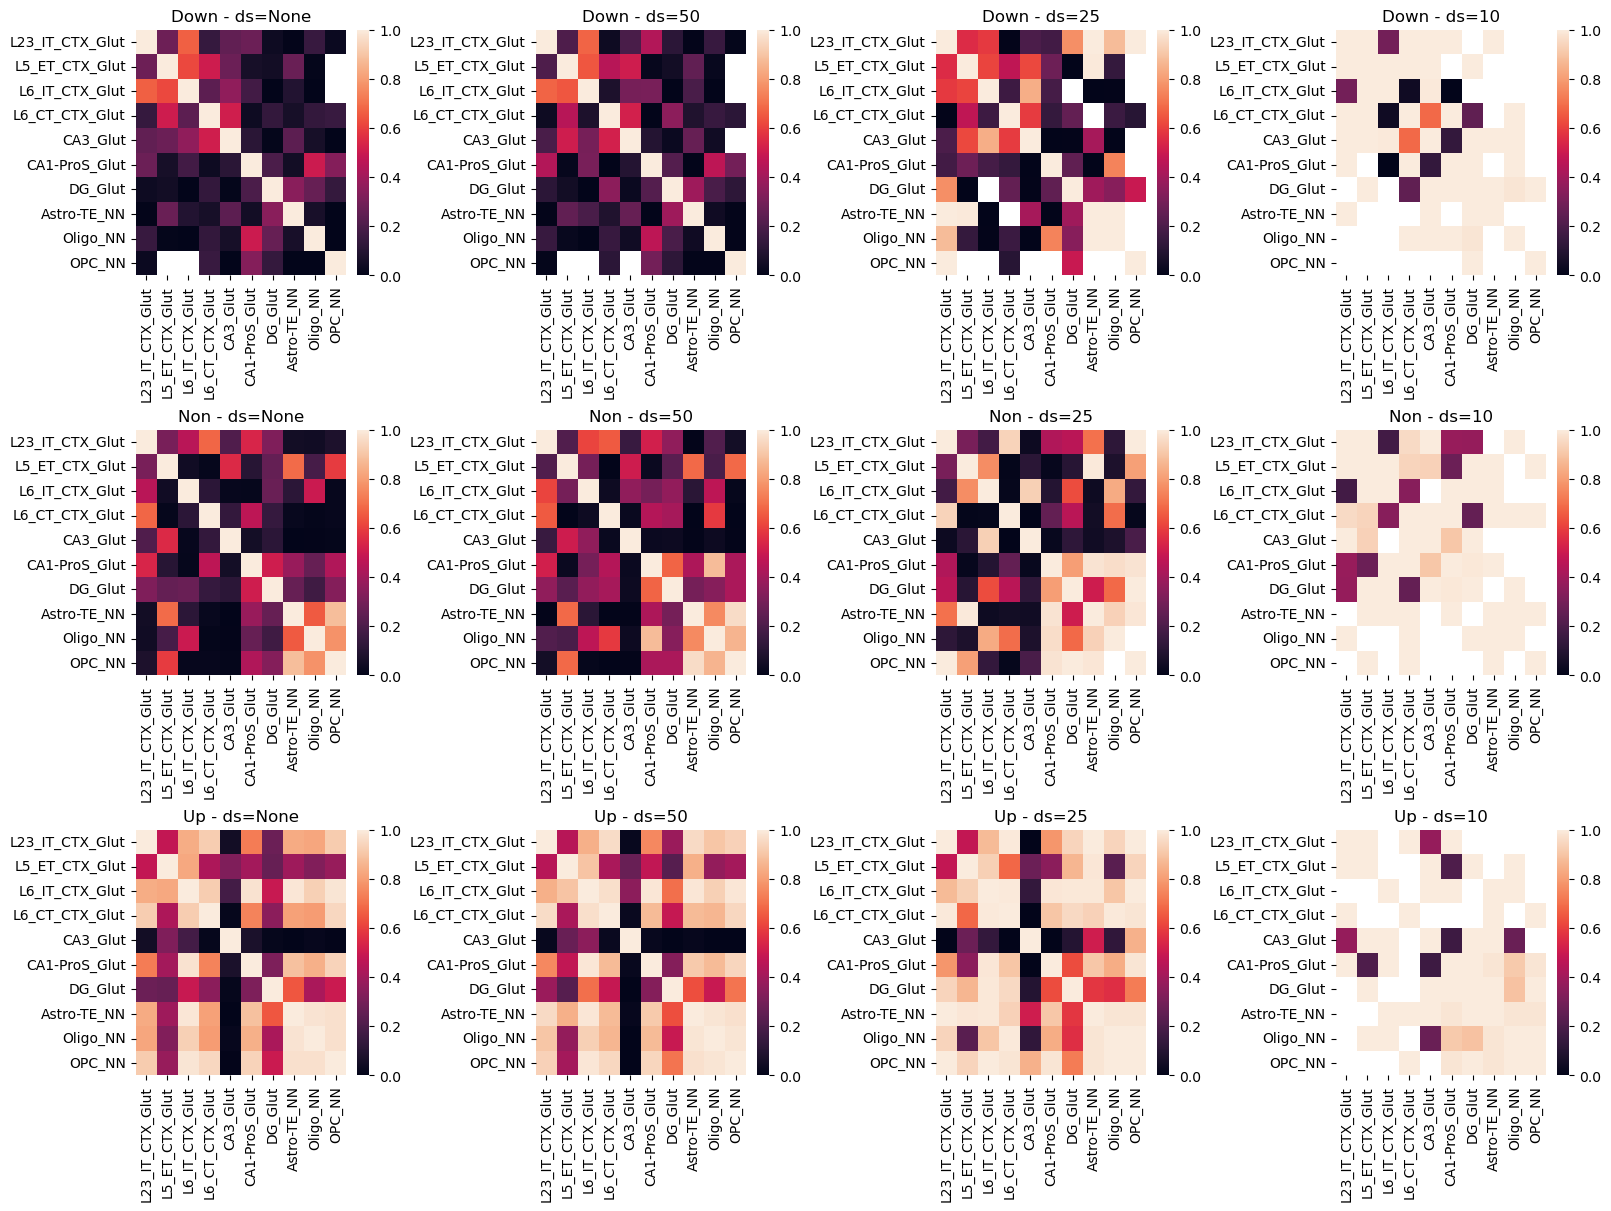

In [74]:
col = 'abs_mean_shap'
corr_method = 'pearson'

# col = 'rank'
# corr_method = 'spearman'

power = 2

ds_range = [None, 50, 25, 10]
fig, axes = plt.subplots(3, 4, figsize=(16, 12), constrained_layout=True)
for i, ds in enumerate(ds_range): 
    df_down, df_non, df_up = generate_rank_corr_matrix(cell_types, col=col, num_downsample=ds, filename=filename)
    
    tt = df_down.corr(method=corr_method).values
    tt = np.power(tt, power)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes[0][i])
    axes[0][i].set_title(f"Down - ds={ds}")
    
    tt = df_non.corr(method=corr_method).values
    tt = np.power(tt, power)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes[1][i])
    axes[1][i].set_title(f"Non - ds={ds}")
    
    tt = df_up.corr(method=corr_method).values
    tt = np.power(tt, power)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes[2][i])
    axes[2][i].set_title(f"Up - ds={ds}")

plt.show()

## Ranked Counts

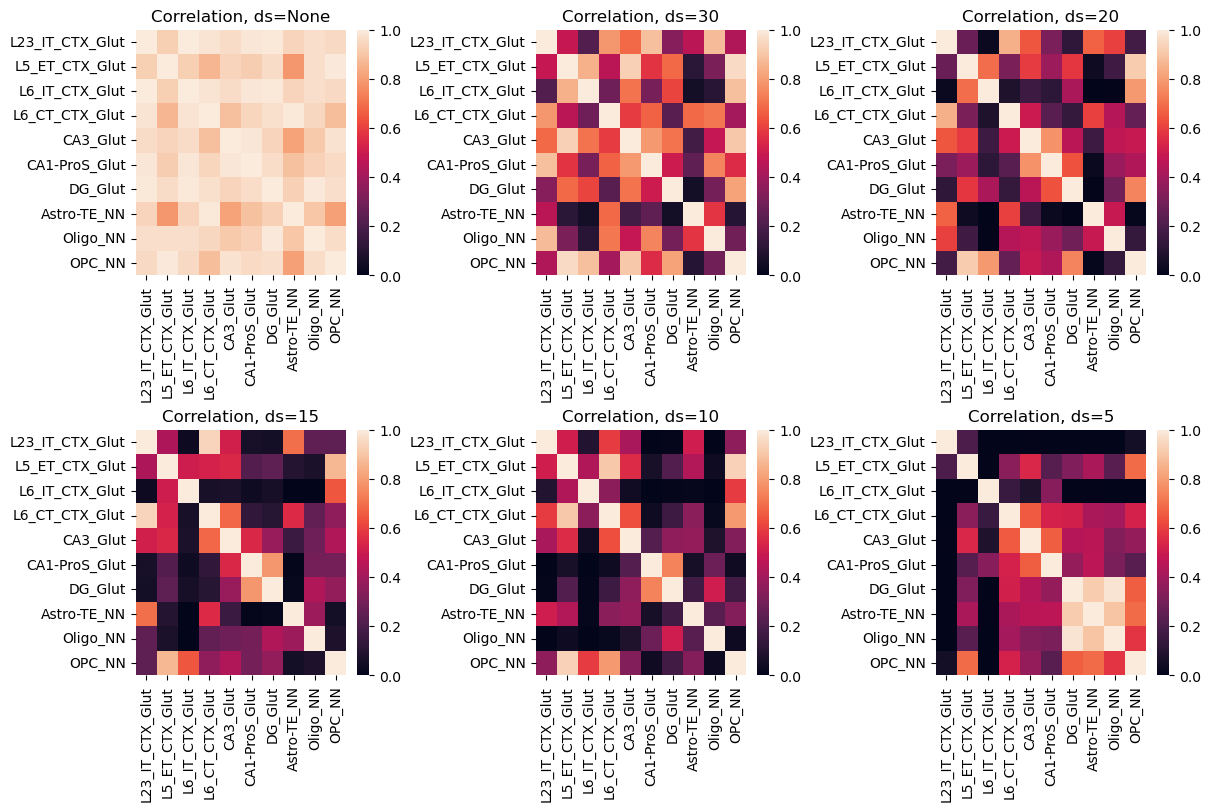

In [140]:
ds_range = [None, 30, 20, 15, 10, 5]
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
for i, ds in enumerate(ds_range): 
    df_mod = generate_mod_corr_matrix(cell_types, num_downsample=ds, filename=filename)
    
    tt = df_mod.corr().values
    tt = np.power(tt, 3)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes.flatten()[i])
    axes.flatten()[i].set_title(f"Correlation, ds={ds}")

plt.show()

## Modality Importance

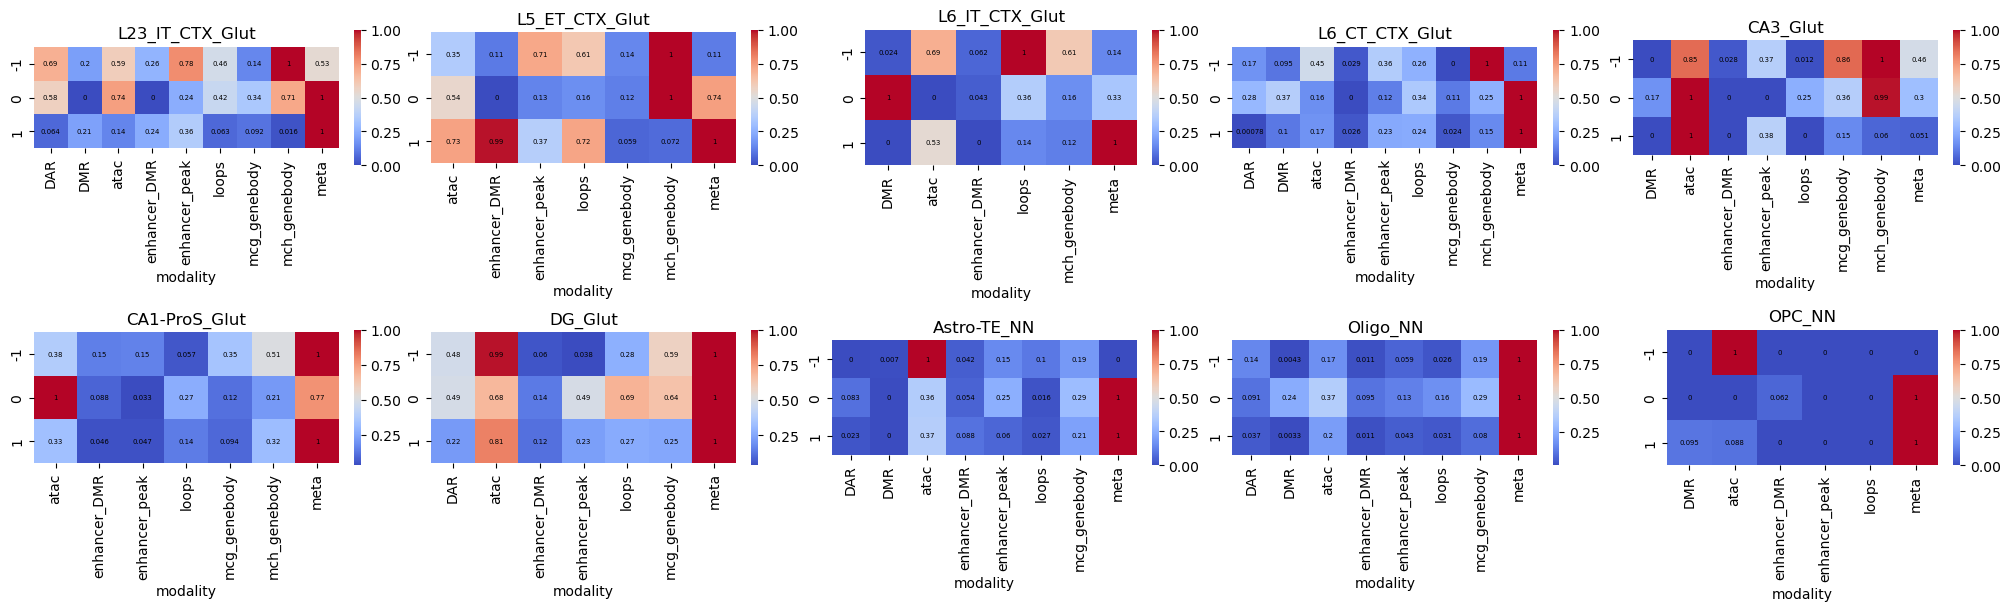

In [61]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6), constrained_layout=True)

for i, _ct in enumerate(cell_types):
    df_rank = generate_modality_rankings(_ct, ds=None, filename=filename)
    df_rank = min_max_norm(df_rank)
    sns.heatmap(df_rank.groupby("modality").max().T, cmap="coolwarm",
                square=True, annot=True, annot_kws={"color":"k", 'size':5}, 
                ax=axes.flatten()[i])
    
    axes.flatten()[i].set_title(_ct)

plt.show()

# Iterative Training Analysis

## Functions

In [190]:
def iterative_mod_corr_matrix(df_features:pd.DataFrame):
    for i, col in enumerate(df_features): 
        df_sub = df_features.loc[df_features[col]]
        mod_split = [x.split('.')[-1] for x in df_sub.index]
    
        if i == 0: 
            df_counts = pd.DataFrame(pd.DataFrame(mod_split).value_counts())
            df_counts.columns = [col]
        else: 
            df_counts[col] = pd.DataFrame(mod_split).value_counts()
    
    df_counts = df_counts.fillna(0)
    # df_counts = df_counts / df_counts.sum(axis=0)
    df_counts = df_counts.div(df_counts['epoch_0'], axis=0)
    
    return df_counts

## Analysis

In [221]:
cell_types = ['L23_IT_CTX_Glut','L5_ET_CTX_Glut','L6_IT_CTX_Glut','L6_CT_CTX_Glut','CA3_Glut','CA1-ProS_Glut','DG_Glut','Astro-TE_NN','Oligo_NN','OPC_NN',]
# cell_types = ['L23_IT_CTX_Glut','L6_CT_CTX_Glut','CA3_Glut','CA1-ProS_Glut','DG_Glut','Oligo_NN',]

### Self-Correlations (by celltype)

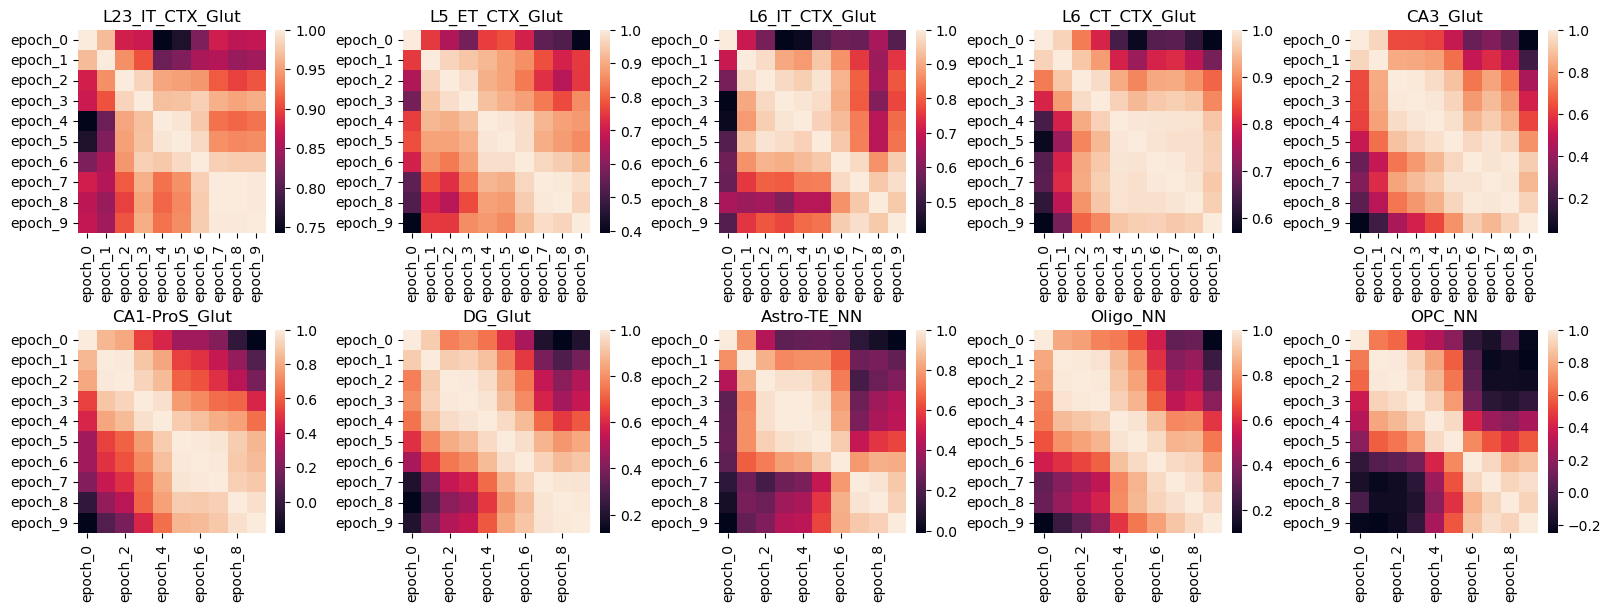

In [222]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6), constrained_layout=True)
for i, _ct in enumerate(cell_types): 
    ax = axes.flatten()[i]
    df_features = pd.read_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.test.csv", index_col=0)
    df_counts = iterative_mod_corr_matrix(df_features)
    sns.heatmap(df_counts.corr(), ax=ax)
    ax.set_title(_ct)
plt.show()

### Best Epoch per Cell Type

In [223]:
for _ct in cell_types: 
    df_metrics = pd.read_csv(f"../result_data/xgb_mods/metric_img/{_ct}.test.metrics.csv", index_col=0)
    best_mod = df_metrics.rank(ascending=True).sum(axis=1).argmax()
    print(_ct, best_mod)

L23_IT_CTX_Glut 3
L5_ET_CTX_Glut 8
L6_IT_CTX_Glut 1
L6_CT_CTX_Glut 1
CA3_Glut 4
CA1-ProS_Glut 3
DG_Glut 3
Astro-TE_NN 8
Oligo_NN 4
OPC_NN 6


### Mod Rank Correlations 

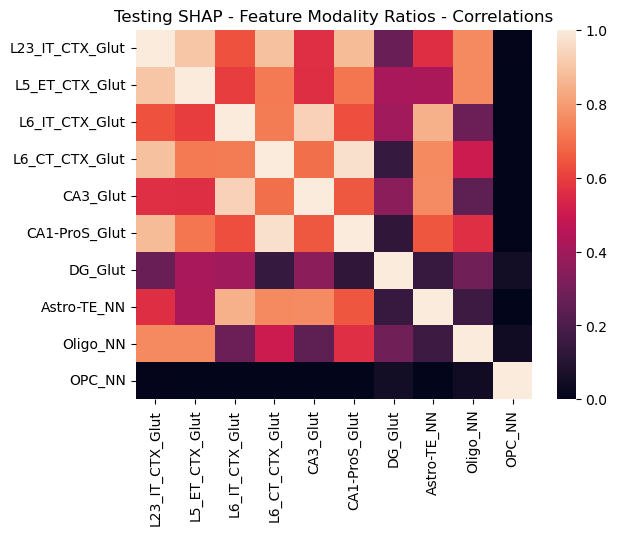

In [229]:
df_counts_all = []
for _ct in cell_types: 
    # Read in model info
    df_features = pd.read_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.test.csv", index_col=0)
    df_metrics = pd.read_csv(f"../result_data/xgb_mods/metric_img/{_ct}.test.metrics.csv", index_col=0)
    #TODO add metrics like micro and macro AUC and PRC
    
    # best_mod = df_metrics.rank(ascending=True).sum(axis=1).argmax()
    best_mod = df_metrics.rank(ascending=True)['bal_acc'].argmax()
    
    df_counts = iterative_mod_corr_matrix(df_features)
    df_counts_all.append(pd.DataFrame(df_counts[f'epoch_{best_mod}'], ))
df_counts_all = pd.concat(df_counts_all, axis=1)
df_counts_all.columns = cell_types

fig, ax = plt.subplots()
sns.heatmap(np.power(df_counts_all.corr(), 3), vmin=0, vmax=1, ax=ax)
ax.set_title("Testing SHAP - Feature Modality Ratios - Correlations")
plt.show()

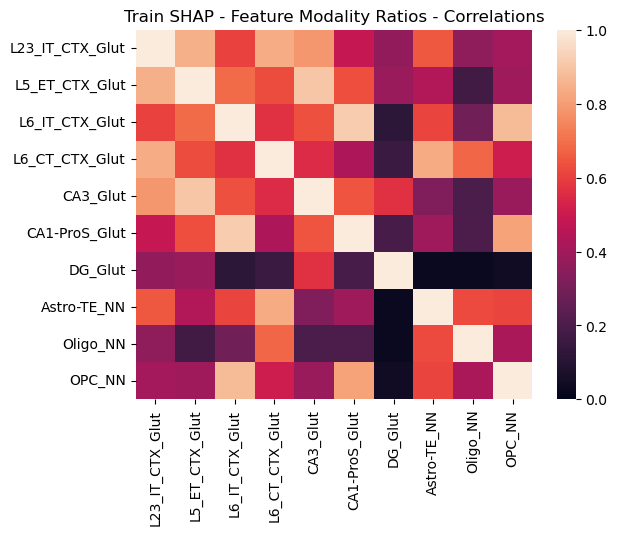

In [228]:
df_counts_all = []
for _ct in cell_types: 
    # Read in model info
    df_features = pd.read_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.train.csv", index_col=0)
    df_metrics = pd.read_csv(f"../result_data/xgb_mods/metric_img/{_ct}.train.metrics.csv", index_col=0)
    #TODO add metrics like micro and macro AUC and PRC
    
    # best_mod = df_metrics.rank(ascending=True).sum(axis=1).argmax()
    best_mod = df_metrics.rank(ascending=True)['bal_acc'].argmax()
    
    df_counts = iterative_mod_corr_matrix(df_features)
    df_counts_all.append(pd.DataFrame(df_counts[f'epoch_{best_mod}'], ))
df_counts_all = pd.concat(df_counts_all, axis=1)
df_counts_all.columns = cell_types

fig, ax = plt.subplots()
sns.heatmap(np.power(df_counts_all.corr(), 3), vmin=0, vmax=1, ax=ax)
ax.set_title("Train SHAP - Feature Modality Ratios - Correlations")
plt.show()

In [317]:
cell_types = ['L23_IT_CTX_Glut','DG_Glut','CA1-ProS_Glut','Oligo_NN','CA3_Glut','L6_CT_CTX_Glut','L6_IT_CTX_Glut','L5_ET_CTX_Glut','Astro-TE_NN','OPC_NN','Pvalb_Gaba']

## Model Results

In [293]:
def ccf_metrics(X_train, X_test, y_train, y_test): 
    y_test_preds = xgb_mod.predict(X_test)
    y_train_preds = xgb_mod.predict(X_train)
    
    ccf_test = confusion_matrix(y_test, y_test_preds, normalize='true')
    ccf_train = confusion_matrix(y_train, y_train_preds, normalize='true')
    fig, ax = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
    sns.heatmap(ccf_test, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[0])
    sns.heatmap(ccf_train, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[1])
    
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Label")
    ax[0].set_title("Test")
    ax[1].set_xlabel("Prediction")
    ax[1].set_ylabel("Label")
    ax[1].set_title("Train")
    return fig, ax

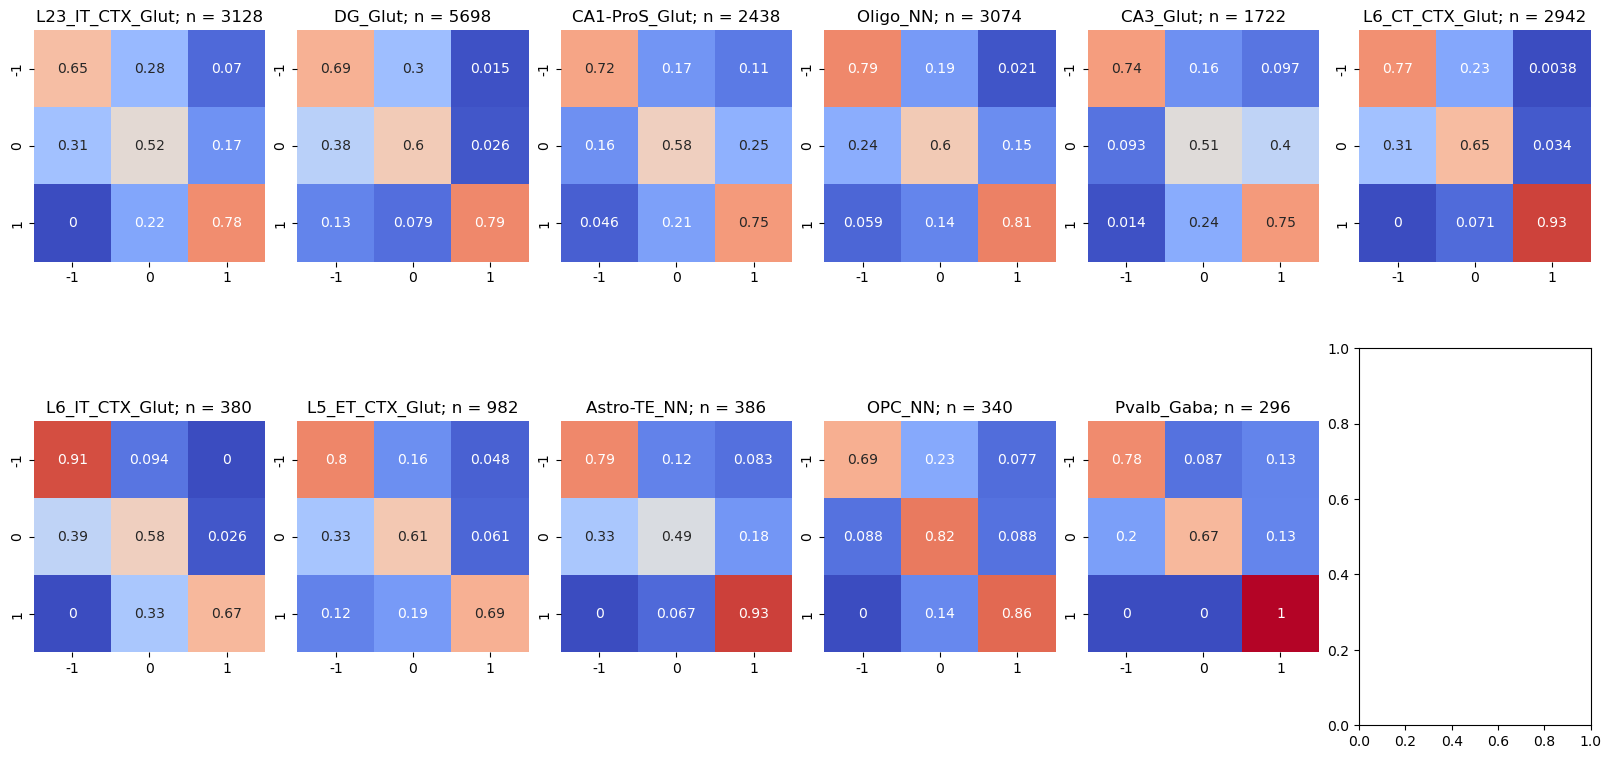

In [320]:
fig, axes = plt.subplots(2, 6, figsize=(16, 8), constrained_layout=True)

# df_counts_all = []
for i, _ct in enumerate(cell_types): 
    ax = axes.flatten()[i]
    # Read in model info
    df_features = pd.read_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.test.csv", index_col=0)
    df_metrics = pd.read_csv(f"../result_data/xgb_mods/metric_img/{_ct}.test.metrics.csv", index_col=0)
    #TODO add metrics like micro and macro AUC and PRC
    
    best_mod = df_metrics.rank(ascending=True).sum(axis=1).argmax()
    # best_mod = df_metrics.rank(ascending=True)['bal_acc'].argmax()

    with open(f"../result_data/xgb_mods/celltype_models/{_ct}.test.{best_mod}.pkl", 'rb') as f: 
        xgb_mod = pickle.load(f)

    X_test = pd.read_csv(f"../result_data/xgb_mods/celltype_models/{_ct}.X_test.csv", index_col=0)
    X_train = pd.read_csv(f"../result_data/xgb_mods/celltype_models/{_ct}.X_train.csv", index_col=0)
    y_test = pd.read_csv(f"../result_data/xgb_mods/celltype_models/{_ct}.Y_test.csv", index_col=0)
    y_train = pd.read_csv(f"../result_data/xgb_mods/celltype_models/{_ct}.Y_train.csv", index_col=0)

    X_test = X_test[xgb_mod.get_booster().feature_names]
    X_train = X_train[xgb_mod.get_booster().feature_names]
    
    n_test = X_test.shape[0]
    n_train = X_train.shape[0]

    y_test_preds = xgb_mod.predict(X_test)
    ccf_test = confusion_matrix(y_test, y_test_preds, normalize='true')
    sns.heatmap(ccf_test, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax)
    ax.set_title(f"{_ct}; n = {n_test + n_train}")
    
plt.show()

# CV Analysis (Currently Using this)

In [5]:
# all options are for different training regiments, I have found that _cs looks / performed best.
# "_b_cs", "_b", "_cs", ""
extension = "_cs" 

In [6]:
# My ordering
cell_types = ['L23_IT_CTX_Glut','L5_ET_CTX_Glut','L6_IT_CTX_Glut','L6_CT_CTX_Glut','CA3_Glut','CA1-ProS_Glut','DG_Glut','Astro-TE_NN','Oligo_NN','OPC_NN',]
# To match RZ's ordering in her plots
cell_types = ['Oligo_NN', 'OPC_NN', 'Astro-TE_NN', 'L23_IT_CTX_Glut', 'L6_IT_CTX_Glut', 'L6_CT_CTX_Glut', 'L5_ET_CTX_Glut', 'CA1-ProS_Glut', 'CA3_Glut', 'DG_Glut']

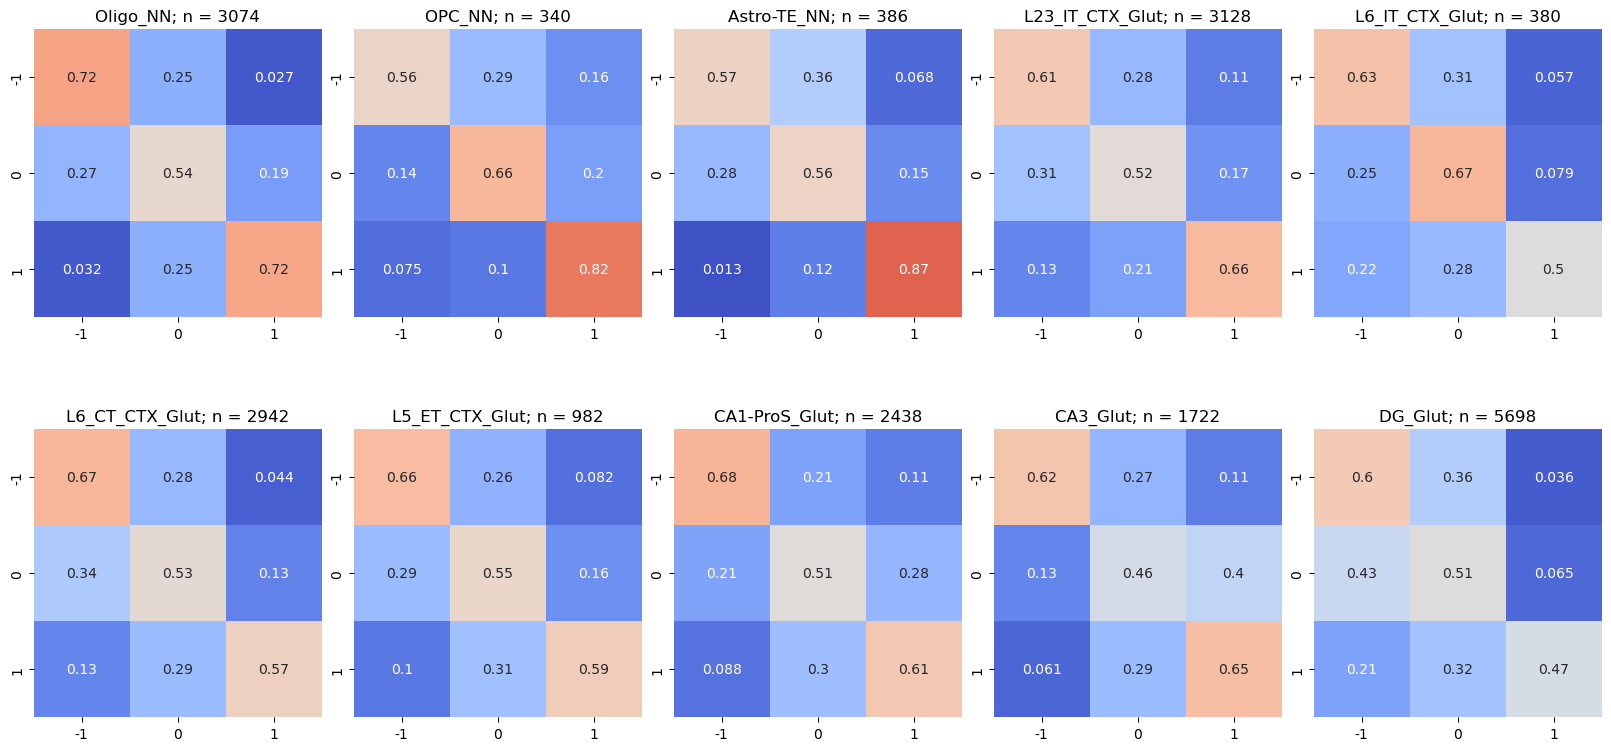

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(16, 8), constrained_layout=True)

for i, _ct in enumerate(cell_types): 
    ax = axes.flatten()[i]
    
    Y_output = pd.read_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv{extension}.Y_outs.csv", index_col=0)
    n_sample = Y_output.shape[0]
    
    ccf_test = confusion_matrix(Y_output['DEG'], Y_output['pred'], normalize='true')
    sns.heatmap(ccf_test, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax)
    ax.set_title(f"{_ct}; n = {n_sample}")

for i in range(len(cell_types), 10): 
    axes.flatten()[i].remove()
plt.show()    

In [8]:
(Y_output['DEG'] == 0).sum(), (Y_output['DEG'] == 1).sum(), (Y_output['DEG'] == 2).sum()

(2659, 2849, 190)

In [9]:
diag_acc = {}
n_samps = {}
for i, _ct in enumerate(cell_types): 

    Y_output = pd.read_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv{extension}.Y_outs.csv", index_col=0)
    n_sample = Y_output.shape[0]
    
    ccf_test = confusion_matrix(Y_output['DEG'], Y_output['pred'], normalize='true')
    diag_acc[_ct] = [ccf_test[0, 0], ccf_test[1, 1], ccf_test[2, 2]]
    n_samps[_ct] = [(Y_output['DEG'] == 0).sum(), (Y_output['DEG'] == 1).sum(), (Y_output['DEG'] == 2).sum()]
    # break
df_diag_acc = pd.DataFrame.from_dict(diag_acc)
df_N = pd.DataFrame.from_dict(n_samps)

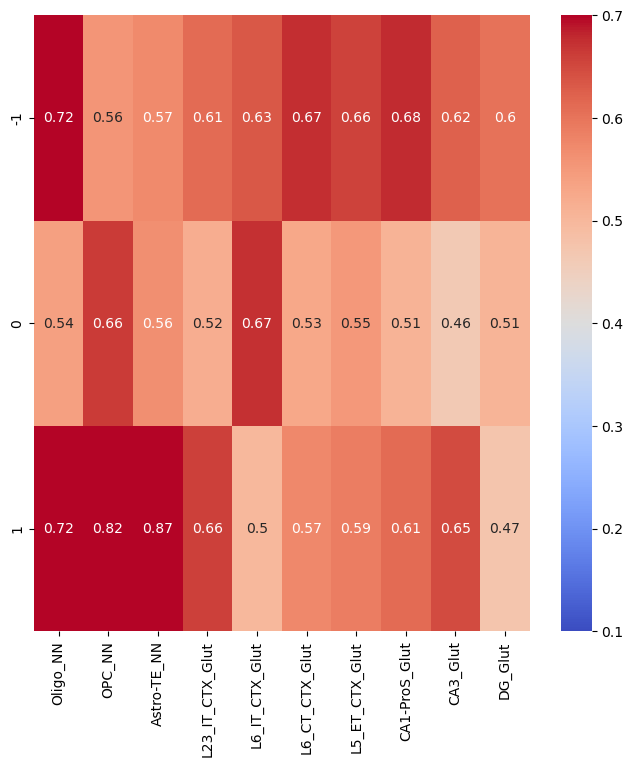

In [320]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df_diag_acc, square=False, cmap='coolwarm', annot=True, vmin=0.1, vmax=0.7,
            yticklabels=['-1', '0', '1'], ax=ax)
plt.show()

In [10]:
toplot = df_diag_acc.melt(ignore_index=False).reset_index() # .set_index("variable")
toplot.columns = ['DEG', 'celltype', 'acc']
df_tt = df_N.melt(ignore_index=False).reset_index() # .set_index("variable")
df_tt.columns = ['DEG', 'celltype', 'N']
toplot = toplot.merge(df_tt, on=['DEG', 'celltype'])
toplot['DEG'] = toplot['DEG'].map({0 : "Down", 1 : "Non", 2 : "Up"})

In [11]:
df_row = toplot.groupby('celltype').sum().reset_index()
df_row['NN'] = df_row['celltype'].apply(lambda x: 'NN' if 'NN' in x else 'Glut')
df_row = df_row.set_index('celltype')
df_col = pd.DataFrame({'DEG' : ['Down', 'Non', 'Up']}, index=['Down', 'Non', 'Up'])

/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/PyComplexHeatmap/dotHeatmap.py:356: FutureWarning: The provided callable <function mean at 0x7f7faa0d7130> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data2d = data.pivot_table(
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/PyComplexHeatmap/dotHeatmap.py:375: FutureWarning: The provided callable <function mean at 0x7f7faa0d7130> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  self.kwargs["s"] = data.pivot_table(
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/PyComplexHeatmap/dotHeatmap.py:391: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.kwargs["s"]=self.k

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 432.39075944846013
Plotting legends..
Estimated legend width: 7.5 mm


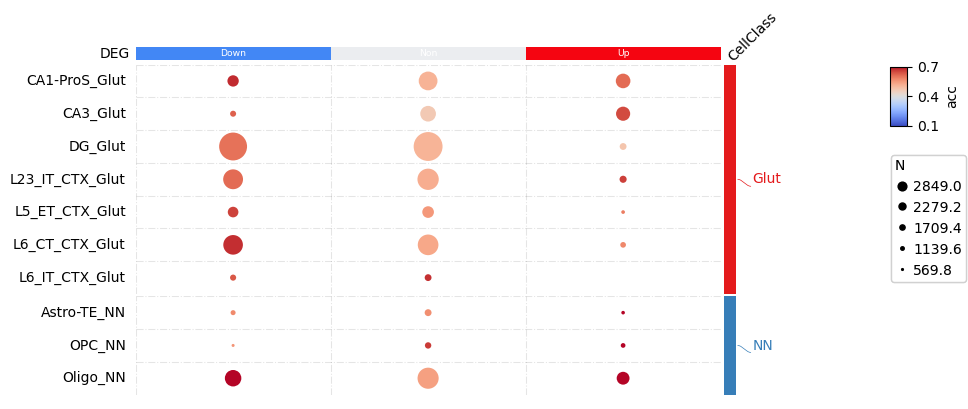

In [12]:
palette = {'Down': '#4287f5', 'Non': '#ebedf0', 'Up': '#f50511'}

row_ha = HeatmapAnnotation(CellClass=anno_simple(df_row.NN, cmap='Set1', add_text=False, legend=False), 
                           label=anno_label(df_row.NN, merge=True, rotation=0), 
                           axis=0, verbose=0, label_kws={'rotation':45, 'horizontalalignment':'left'}
                          )

col_ha = HeatmapAnnotation(DEG=anno_simple(df_col.DEG, colors=palette, legend=False, add_text=True), 
                           verbose=0, label_side='left',)

plt.figure(figsize=(8,4))
cm = DotClustermapPlotter(toplot, x='DEG', y='celltype', value='acc', s='N', cmap='coolwarm', 
                          c='acc', vmax=0.7, vmin=0.1, linewidth=0, row_split=df_row.NN,
                         show_colnames=False, show_rownames=True, row_cluster=False, alpha=0.3, 
                         right_annotation=row_ha, top_annotation=col_ha)
plt.show()

## Modality Importance per gene

In [344]:
palette = {-1: '#4287f5', 0: '#ebedf0', 1: '#f50511'}

In [31]:
FEATURE_LIST = ['DMR', 'mcg_genebody', 'mch_genebody', 'atac', 'DAR', 'loops', 'enhancer_DMR', 'enhancer_peak'] # , 'meta']

In [32]:
def generate():
    proba = np.random.random()
    max = 0
    for i in range(1,M+1):
         max += (1/2)**i
         if(proba<= max):
              return i-1
    return generate()

### Correct Predictions

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


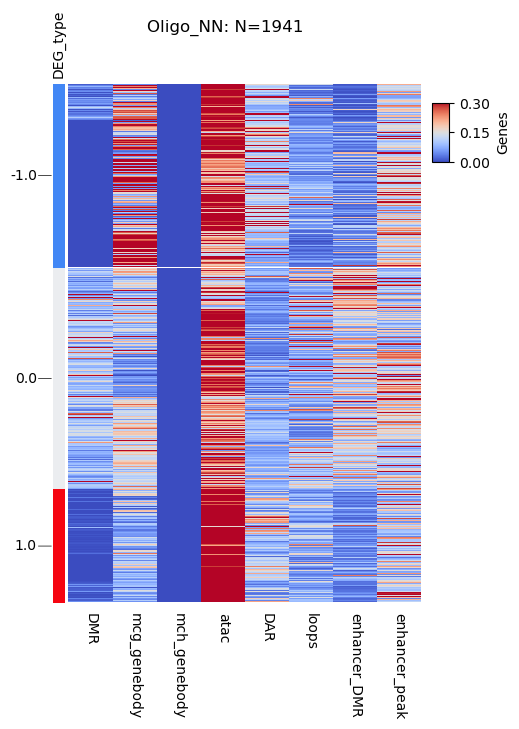

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


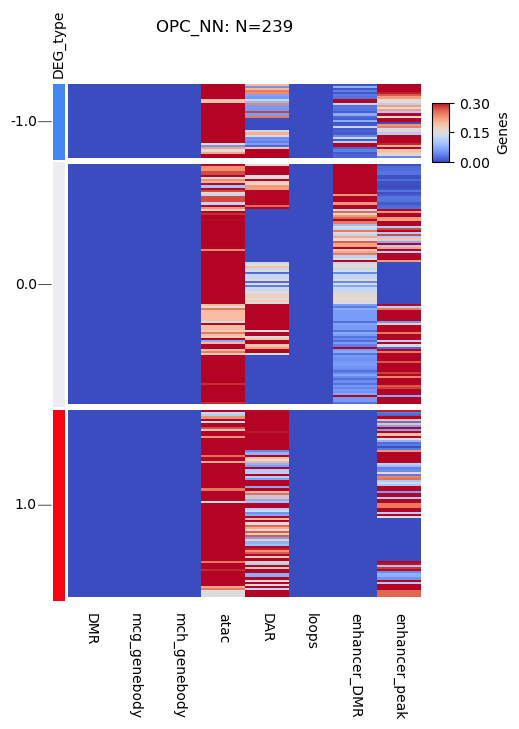

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


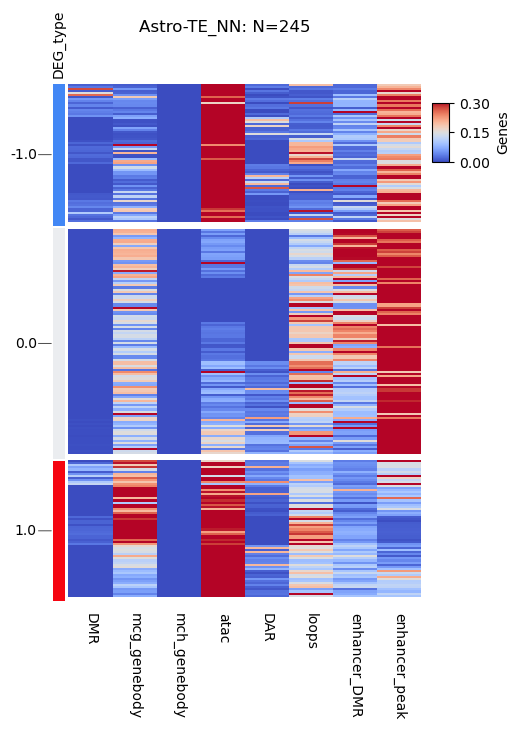

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


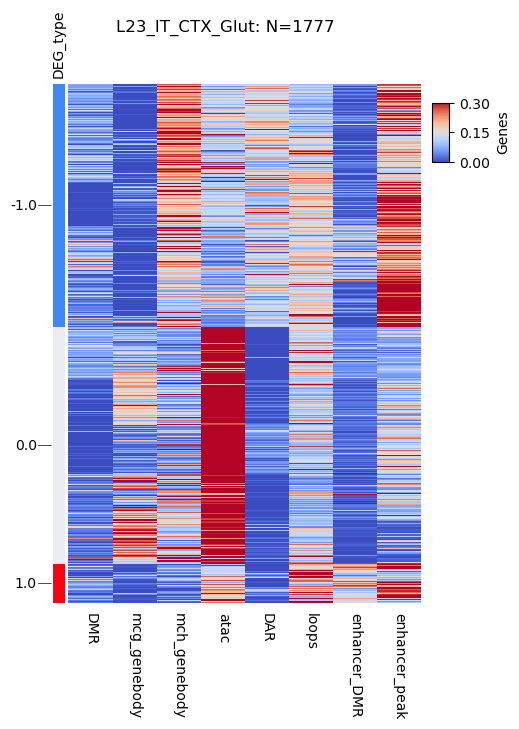

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


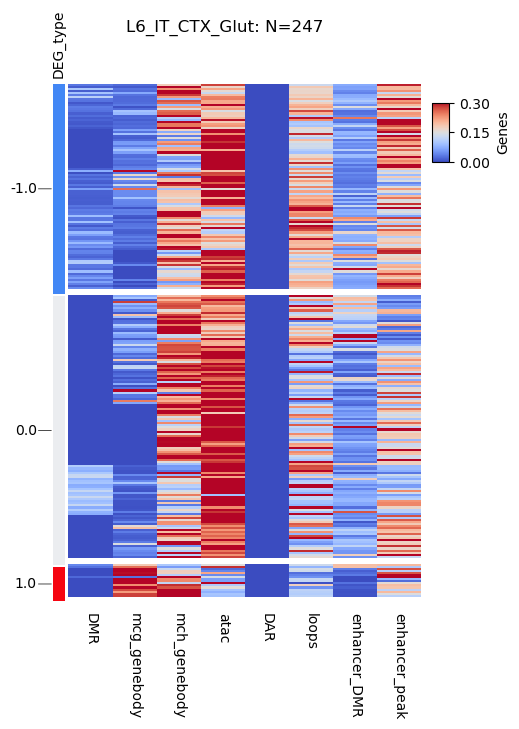

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


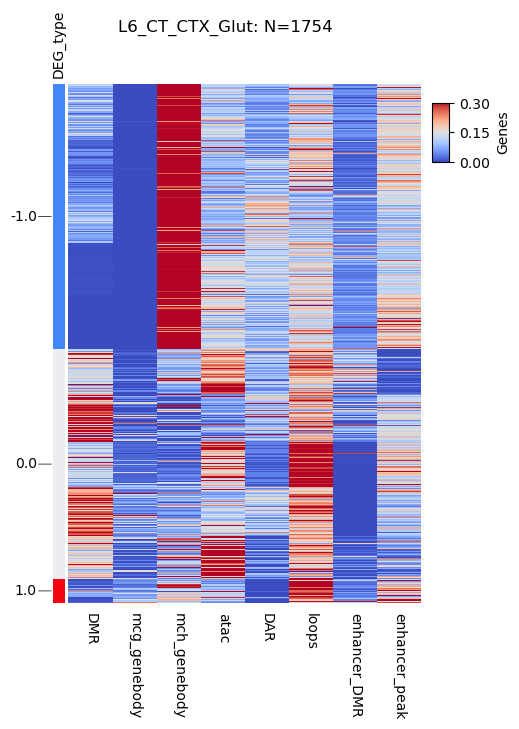

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


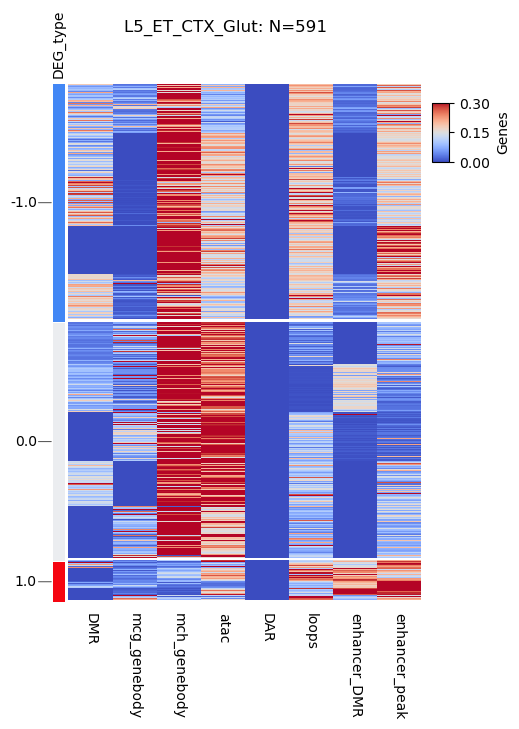

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


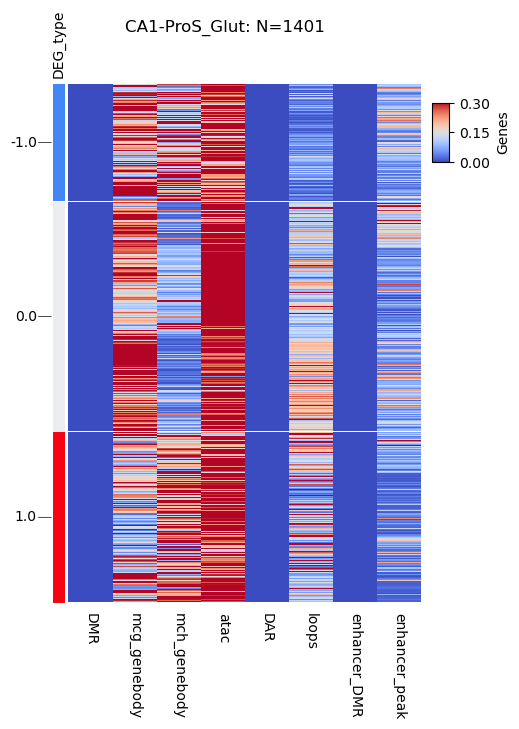

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


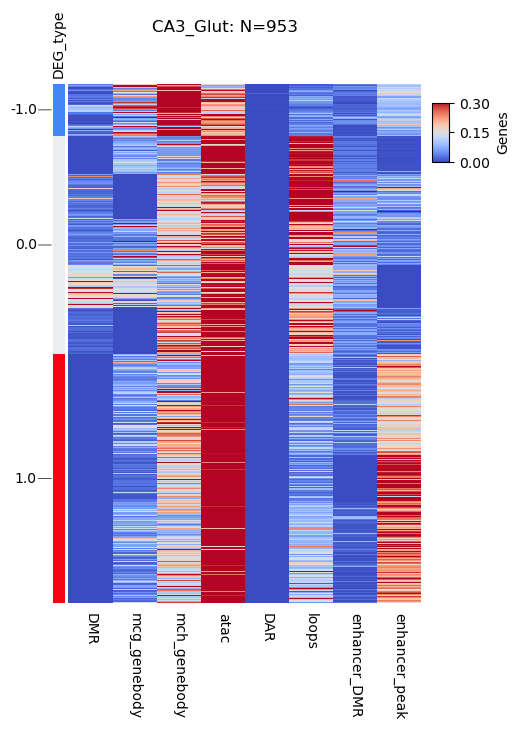

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


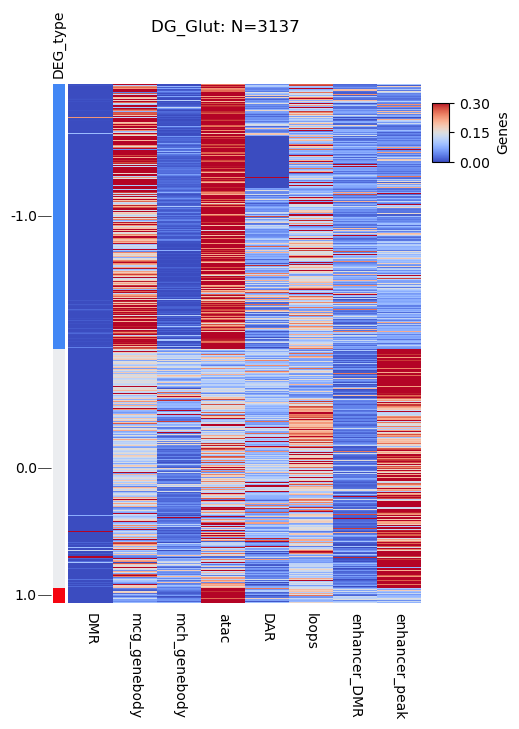

In [234]:
# fig, axes = plt.subplots(2, 6, figsize=(16, 16), constrained_layout=True)

for i, _ct in enumerate(cell_types): 
    # ax = axes.flatten()[i]

    shap_list = []
    for _deg, _int_deg in zip(['down', 'non', 'up'], [0, 1, 2]): 
        df_shap = pd.read_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv{extension}.shap_{_deg}.csv", index_col=0)
        df_shap = df_shap[(df_shap['DEG'] == df_shap['pred']) & (df_shap['DEG'] == _int_deg)]
        
        stat = df_shap[['DEG', 'pred']]
        df_shap = df_shap[df_shap.columns.difference(['DEG', 'pred'])].T.abs()
        df_shap['modality'] = [idx.split(".")[-1] for idx in df_shap.index]
        # break
        
        df_list = []
        for m in FEATURE_LIST: 
            df_temp = df_shap[df_shap['modality'] == m]
            df_temp = df_temp.drop(columns = ['modality'])
            M = df_temp.shape[0]
            if M == 0: 
                df_temp = pd.DataFrame(df_shap.columns).set_index("gene_name")
                df_temp[m] = 0
                df_list.append(df_temp)
            else: 
                res = [0 for i in range(M)]
                for i in range(1000):
                    res[generate()]+=1
            
                df_temp = df_temp.apply(lambda x: np.average(sorted(x, reverse=True), weights=res), axis=0)
                df_list.append(pd.DataFrame(df_temp).rename(columns={0:m}))
        # break
    
        df_shap = pd.concat(df_list, axis=1)   
        df_shap = df_shap.apply(lambda x: (x - min(x)) / sum(x - min(x)), axis=1)
        df_shap['DEG'] = stat['DEG']
        shap_list.append(df_shap)
    df_shap = pd.concat(shap_list)
    df_shap['DEG'] = df_shap['DEG'] - 1

    # Plotting
    n_samples=df_shap.shape[0]
    toplot = df_shap[['DMR', 'mcg_genebody', 'mch_genebody', 'atac', 'DAR', 'loops', 'enhancer_DMR', 'enhancer_peak']]    

    left_ha = pch.HeatmapAnnotation(label = pch.anno_label(df_shap.DEG, merge=True, extend=False, adjust_color=True, luminance=0.75, relpos=(1, 0.5), colors='black'), 
                                    DEG_type = pch.anno_simple(df_shap.DEG, legend=True, colors=palette), 
                                    verbose=1, axis=0, plot_legend=False)
    
    fig = plt.figure(figsize=(5, 6))
    cm = ClusterMapPlotter(
        data = toplot, 
        left_annotation=left_ha,
        show_colnames=True, 
        vmin=0, vmax=0.3, 
        col_cluster=False, row_cluster=False, 
        cmap = 'coolwarm', rasterized=True, 
    )
    plt.suptitle(f"{_ct}: N={n_samples}")
    plt.ylabel("Genes")
    plt.show()
    # ax.set_title(f"{_ct}: N={n_samples}")
    # ax.set_ylabel("Genes")

### Incorrect Predictions

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


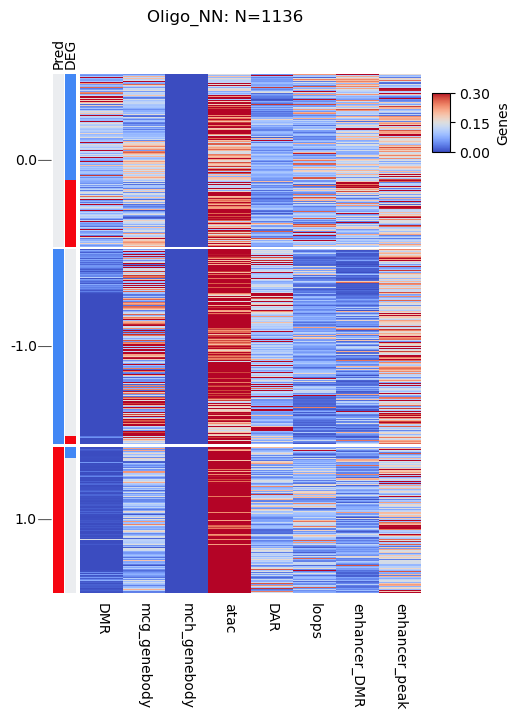

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


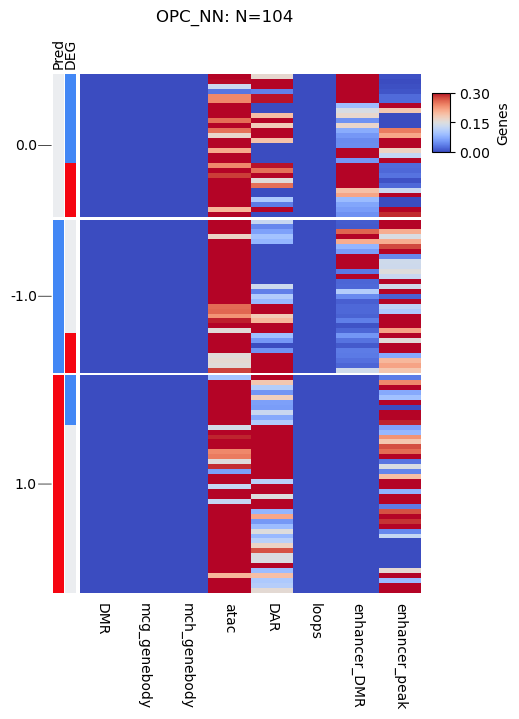

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


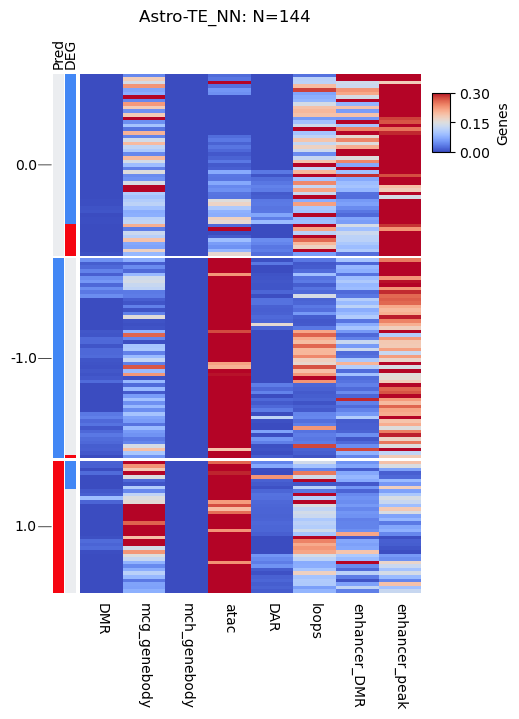

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


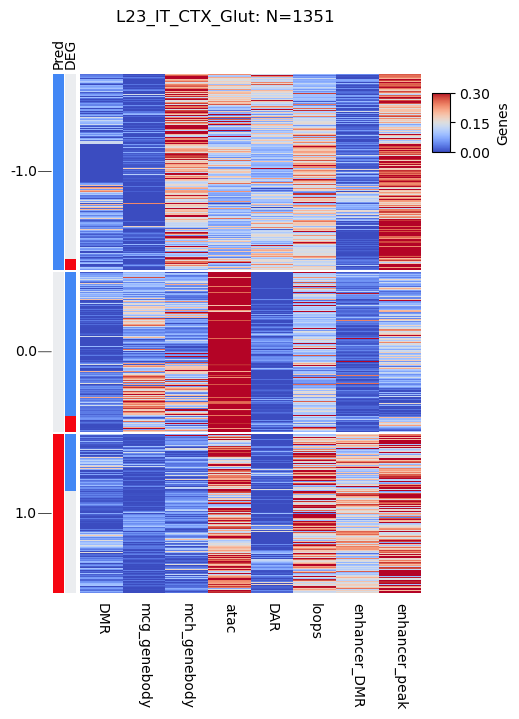

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


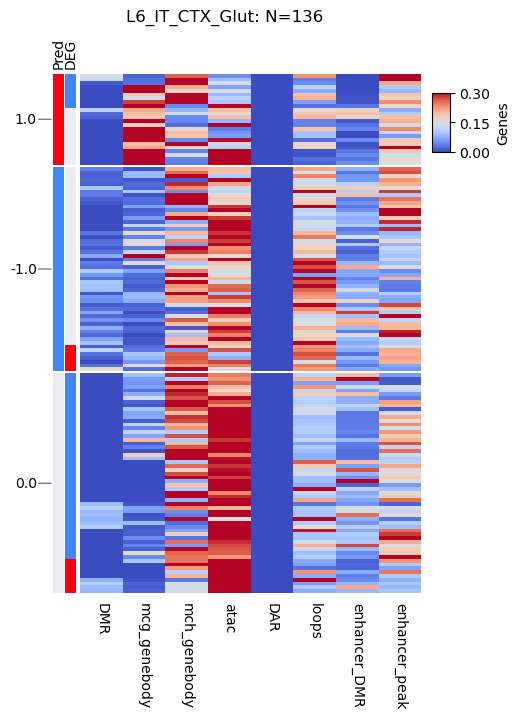

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


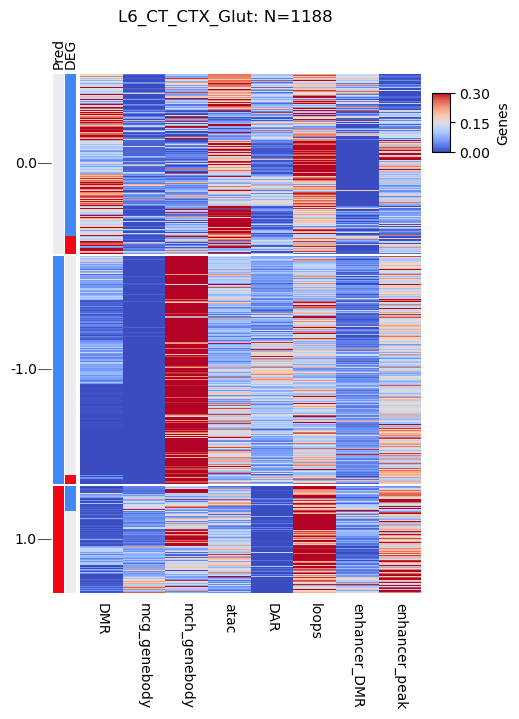

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


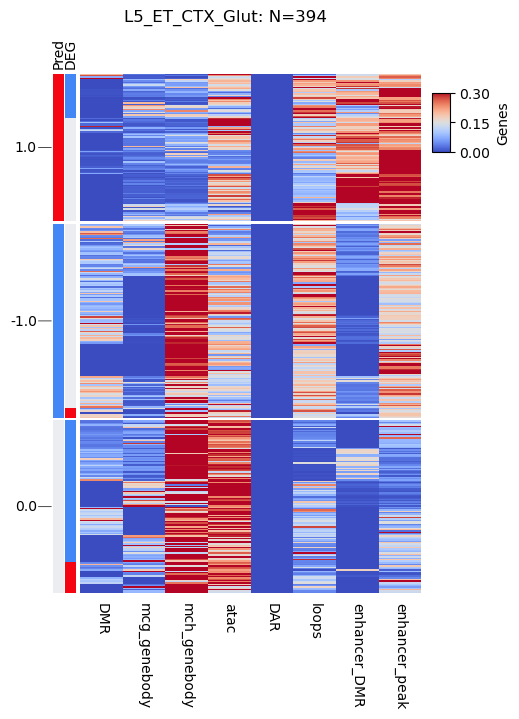

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


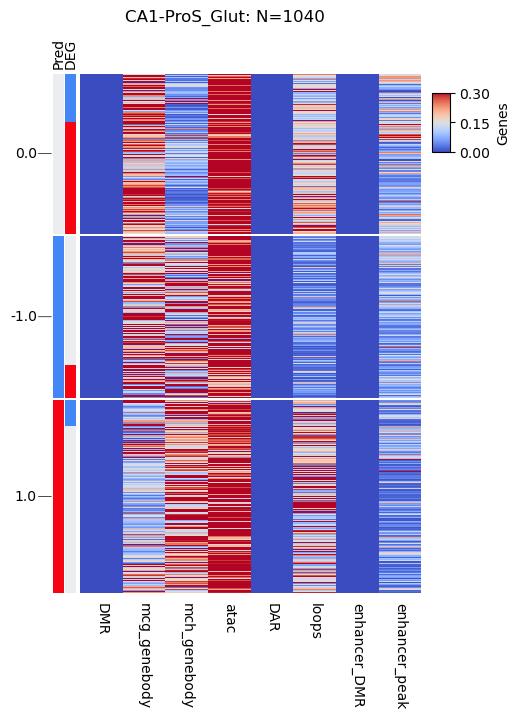

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


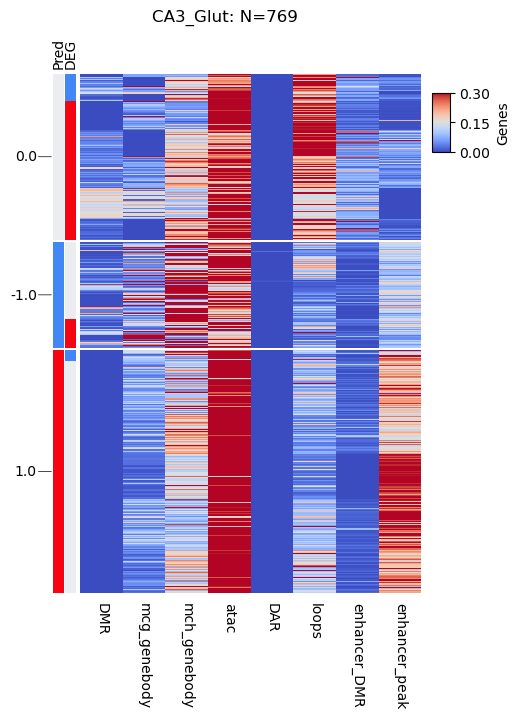

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


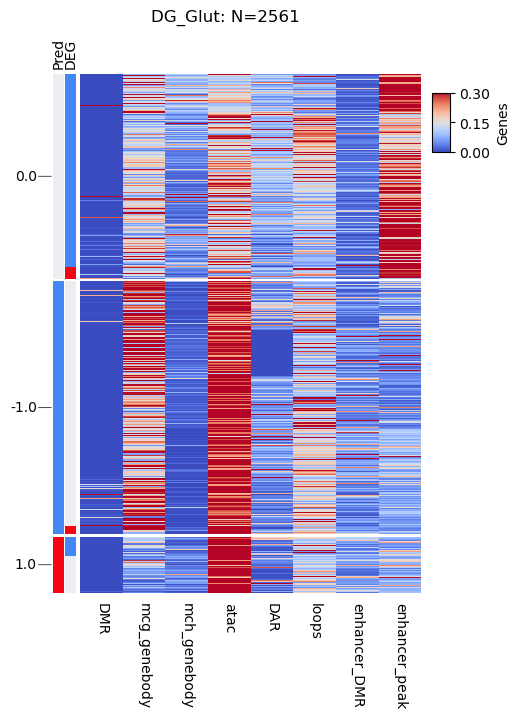

In [356]:
# fig, axes = plt.subplots(2, 6, figsize=(16, 16), constrained_layout=True)

for i, _ct in enumerate(cell_types): 
    # ax = axes.flatten()[i]

    shap_list = []
    for _deg, _int_deg in zip(['down', 'non', 'up'], [0, 1, 2]): 
        df_shap = pd.read_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv{extension}.shap_{_deg}.csv", index_col=0)
        df_shap = df_shap[(df_shap['DEG'] != df_shap['pred']) & (df_shap['pred'] == _int_deg)]
        
        stat = df_shap[['DEG', 'pred']]
        df_shap = df_shap[df_shap.columns.difference(['DEG', 'pred'])].T.abs()
        df_shap['modality'] = [idx.split(".")[-1] for idx in df_shap.index]
        # break
        
        df_list = []
        for m in FEATURE_LIST: 
            df_temp = df_shap[df_shap['modality'] == m]
            df_temp = df_temp.drop(columns = ['modality'])
            M = df_temp.shape[0]
            if M == 0: 
                df_temp = pd.DataFrame(df_shap.columns).set_index("gene_name")
                df_temp[m] = 0
                df_list.append(df_temp)
            else: 
                res = [0 for i in range(M)]
                for i in range(1000):
                    res[generate()]+=1
            
                df_temp = df_temp.apply(lambda x: np.average(sorted(x, reverse=True), weights=res), axis=0)
                df_list.append(pd.DataFrame(df_temp).rename(columns={0:m}))
        # break
    
        df_shap = pd.concat(df_list, axis=1)   
        df_shap = df_shap.apply(lambda x: (x - min(x)) / sum(x - min(x)), axis=1)
        df_shap['pred'] = stat['pred']
        df_shap['DEG'] = stat['DEG']
        shap_list.append(df_shap)
    df_shap = pd.concat(shap_list)
    df_shap['pred'] = df_shap['pred'] - 1
    df_shap['DEG'] = df_shap['DEG'] - 1
    df_shap = df_shap.sort_values(by=['pred', 'DEG'])
    df_shap = df_shap.loc[~(df_shap.index == 'modality')]


    # Plotting
    n_samples=df_shap.shape[0]
    toplot = df_shap[['DMR', 'mcg_genebody', 'mch_genebody', 'atac', 'DAR', 'loops', 'enhancer_DMR', 'enhancer_peak']]    

    left_ha = pch.HeatmapAnnotation(label = pch.anno_label(df_shap.pred, merge=True, extend=False, adjust_color=True, luminance=0.75, relpos=(1, 0.5), colors='black'), 
                                    Pred = pch.anno_simple(df_shap.pred, legend=True, colors=palette), 
                                    DEG = pch.anno_simple(df_shap.DEG, legend=True, colors=palette), 
                                    verbose=1, axis=0, plot_legend=False)
    
    fig = plt.figure(figsize=(5, 6))
    cm = ClusterMapPlotter(
        data = toplot, 
        left_annotation=left_ha,
        show_colnames=True, 
        vmin=0, vmax=0.3, 
        row_split=df_shap.pred,
        col_cluster=False, row_cluster=False, 
        cmap = 'coolwarm', rasterized=True, 
    )
    plt.suptitle(f"{_ct}: N={n_samples}")
    plt.ylabel("Genes")
    plt.show()
    # ax.set_title(f"{_ct}: N={n_samples}")
    # ax.set_ylabel("Genes")

## Modality Importance

In [66]:
def generate():
    proba = np.random.random()
    max = 0
    for i in range(1,M+1):
         max += (1/2)**i
         if(proba<= max):
              return i-1
    return generate()

In [78]:
FEATURE_LIST = ['DMR', 'mcg_genebody', 'mch_genebody', 'atac', 'DAR', 'loops', 'enhancer_DMR', 'enhancer_peak'] #, 'meta']
FEATURE_MAP = {'DMR' : "mCG_DMR",
               'mcg_genebody' : "mCG_Genebody",
               'mch_genebody' : "mCH_Genebody",
               'atac' : "ATAC",
               'DAR' : "ATAC",
               'loops' : "hic_loops",
               'enhancer_DMR' : "enhancer_DMR",
               'enhancer_peak' : "enhancer_peak"
}
FEAT_ORDER = ["mCG_DMR", "mCG_Genebody", "mCH_Genebody", "ATAC", "hic_loops", "enhancer_DMR", "enhancer_peak"]

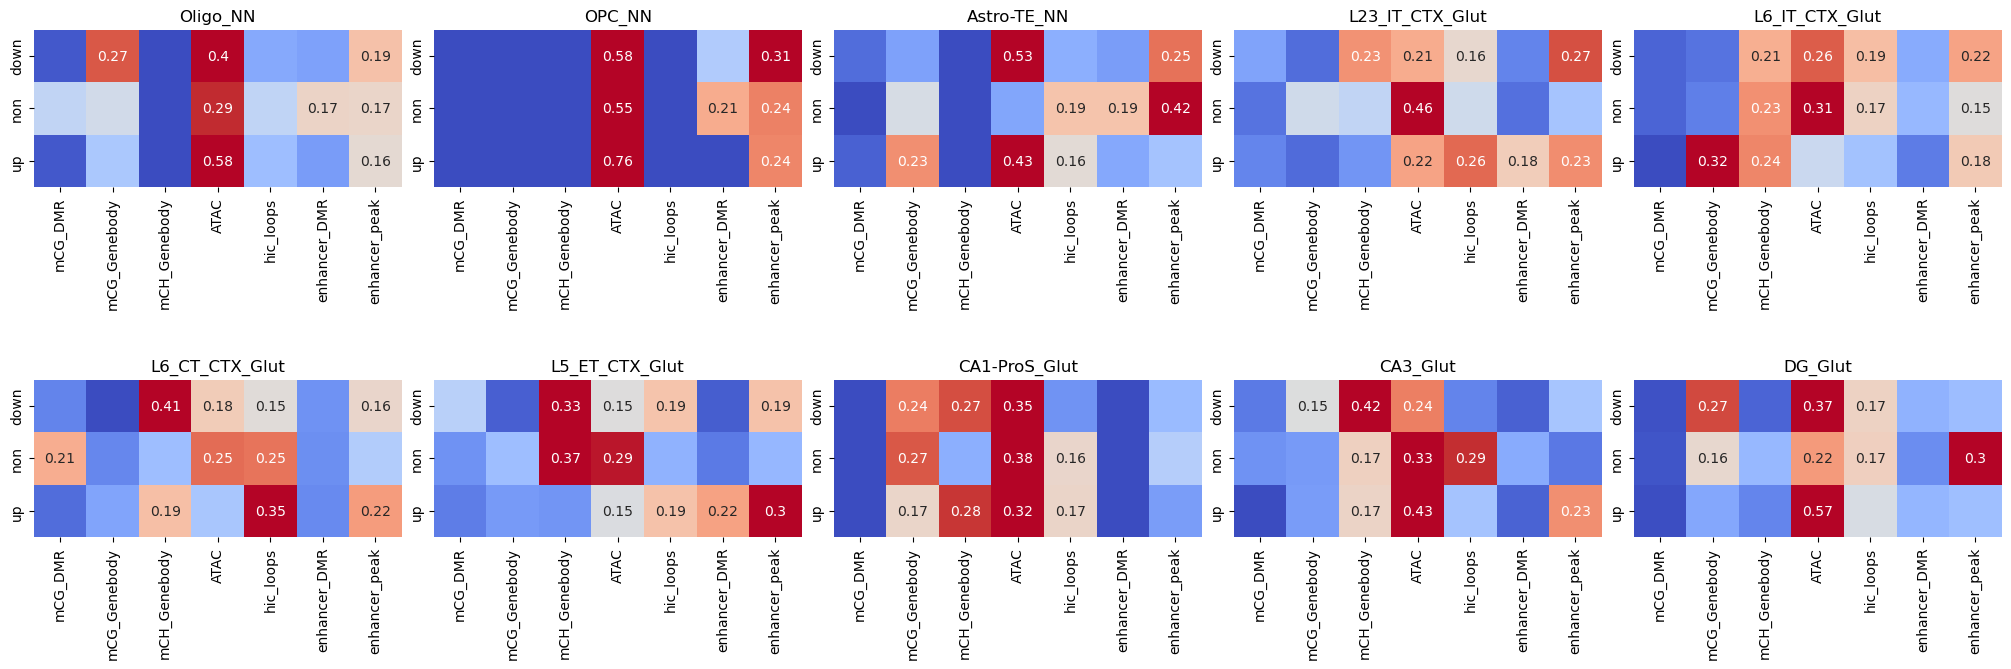

In [357]:
fig, axes = plt.subplots(2, 5, figsize=(20, 7), constrained_layout=True)

CT_RES = {}
for i, _ct in enumerate(cell_types): 
    ax = axes.flatten()[i]
    
    RES = {}
    for _deg, _int_deg in zip(['down', 'non', 'up'], [0, 1, 2]): 
        df_shap = pd.read_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv{extension}.shap_{_deg}.csv", index_col=0)
        df_shap = df_shap[(df_shap['DEG'] == df_shap['pred']) & (df_shap['DEG'] == _int_deg)]
        
        stat = df_shap[['DEG', 'pred']]
        df_shap = df_shap[df_shap.columns.difference(['DEG', 'pred'])].T.abs()
        df_shap['modality'] = [idx.split(".")[-1] for idx in df_shap.index]
        df_shap['modality'] = df_shap['modality'].map(FEATURE_MAP)
        # break
        
        df_list = []
        for m in FEAT_ORDER: 
            df_temp = df_shap[df_shap['modality'] == m]
            df_temp = df_temp.drop(columns = ['modality'])
            M = df_temp.shape[0]
            if M == 0: 
                df_temp = pd.DataFrame(df_shap.columns).set_index("gene_name")
                df_temp[m] = 0
                df_list.append(df_temp.T)
            else: 
                res = [0 for i in range(M)]
                for i in range(1000):
                    res[generate()]+=1
            
                df_temp = df_temp.apply(lambda x: np.average(sorted(x, reverse=True), weights=res), axis=0)
                df_list.append(pd.DataFrame(df_temp).rename(columns={0:m}).T)
        # break
    
        df_shap = pd.concat(df_list)    
        # df_shap = df_shap.groupby('modality').mean() # .mean(axis=1)
        df_shap = df_shap.apply(lambda x: (x - min(x)) / sum(x - min(x)), axis=0)
        RES[_deg] = df_shap.mean(axis=1)
    
    CT_RES[_ct] = RES

    sns.heatmap(pd.DataFrame.from_dict(RES).T, square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax, 
                vmin=0, vmax=0.3)
    # setting the annotation only when bigger than some value
    for t in ax.texts:
        if float(t.get_text())>=0.15:
            t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
        else:
            t.set_text("") # if not it sets an empty text
    ax.set_title(f"{_ct}")

for i in range(len(cell_types), 10): 
    axes.flatten()[i].remove()
plt.show()

### Importance Correlations

In [358]:
df_list = []
for _ct, shap_dict in CT_RES.items(): 
    df_mod = pd.DataFrame.from_dict(shap_dict).reset_index().melt(id_vars='index', value_name=_ct)
    df_mod['deg_modality'] = df_mod['variable'] + '_' + df_mod['index']
    df_mod = df_mod.drop(columns = ['variable', 'index']).set_index('deg_modality')
    df_list.append(df_mod)
df_mod = pd.concat(df_list, axis=1)

In [359]:
# cell_types = ['L23_IT_CTX_Glut','L5_ET_CTX_Glut','L6_IT_CTX_Glut','L6_CT_CTX_Glut','CA3_Glut','CA1-ProS_Glut','DG_Glut', 'Oligo_NN', 'Astro-TE_NN','OPC_NN']

<Axes: >

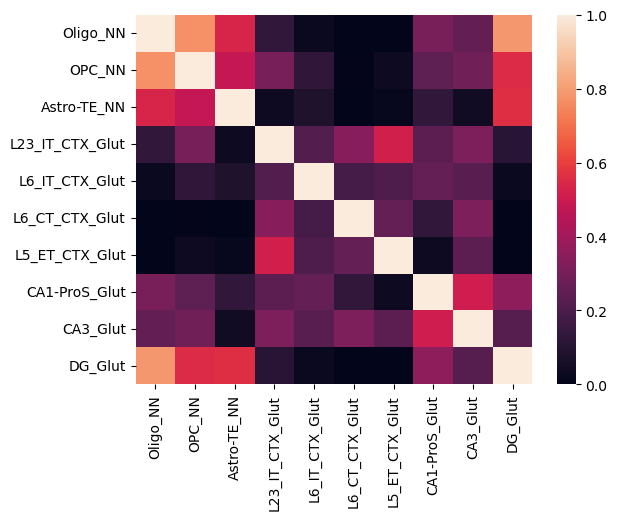

In [360]:
corr_vals = df_mod[cell_types].corr()
corr_vals = np.power(corr_vals, 2)
sns.heatmap(corr_vals, vmin = 0, vmax = 1)

### Clustering the correlation matrix

In [361]:
import scipy.cluster.hierarchy as spc

In [362]:
pdist = spc.distance.pdist(df_mod.T)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5*pdist.max(), 'distance')

In [364]:
columns = [df_mod.columns.tolist()[i] for i in list(np.argsort(idx))]

<Axes: >

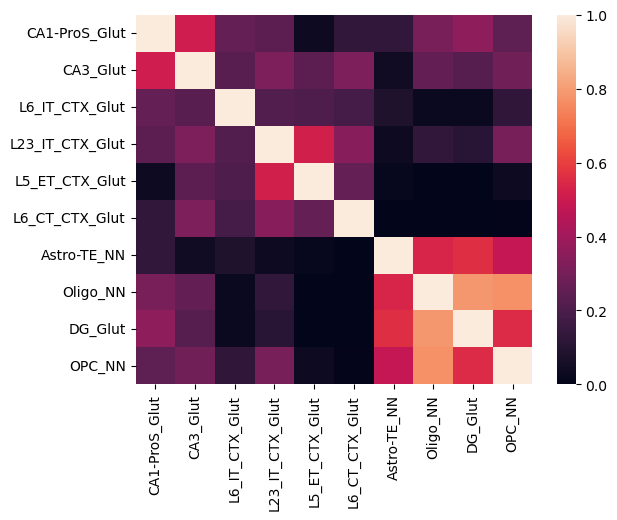

In [365]:
corr_vals = df_mod[columns].corr()
corr_vals = np.power(corr_vals, 2)
sns.heatmap(corr_vals, vmin = 0, vmax = 1)

#### Relationship between prediction entropy and correctness

In [377]:
Y_output['entropy'] = Y_output.apply(lambda x: entropy([x['score_0'], x['score_1'], x['score_2']]), axis=1)

In [378]:
Y_output['cc'] = (Y_output['pred'] == Y_output['DEG'])

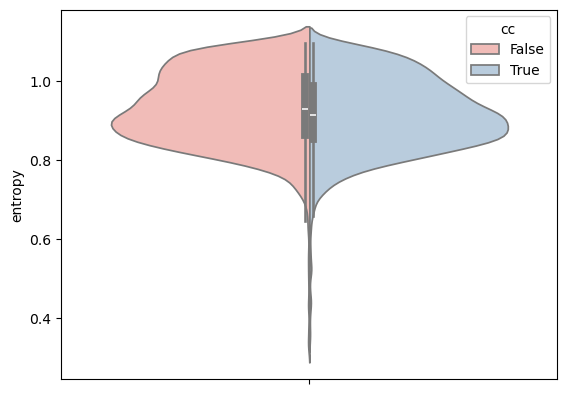

In [399]:
sns.violinplot(Y_output, y='entropy', hue='cc', split=True, palette='Pastel1', alpha=1)
plt.show()

#### Renaming stuff (do not run)

In [218]:
for _ct in cell_types: 
    df = pd.read_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.csv", index_col = 0)
    df.to_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.test.csv")

In [219]:
for _ct in cell_types: 
    for i in range(0, 10): 
        with open(f"../result_data/xgb_mods/celltype_models/{_ct}.{i}.pkl", 'rb') as f: 
            xgb_mod = pickle.load(f)
        with open(f"../result_data/xgb_mods/celltype_models/{_ct}.test.{i}.pkl", 'wb') as f: 
            pickle.dump(xgb_mod, f)

In [220]:
for _ct in cell_types:
    df_metrics = pd.read_csv(f"../result_data/xgb_mods/metric_img/{_ct}.metrics.csv", index_col=0)
    df_metrics.to_csv(f"../result_data/xgb_mods/metric_img/{_ct}.test.metrics.csv")

# Old Results

In [150]:
df_down, df_non, df_up = generate_rank_corr_matrix(cell_types, col='abs_mean_shap', num_downsample=None)

In [151]:
df_down['modality'] = [idx.split(".")[-1] for idx in df_down.index]
df_non['modality'] = [idx.split(".")[-1] for idx in df_non.index]
df_up['modality'] = [idx.split(".")[-1] for idx in df_up.index]

In [159]:
df_down.melt(id_vars=['modality'], var_name = "Cell_Type", value_name='down_val', ignore_index=False)

modality        Cell_Type  down_val
index                                                      
18mo.2mo.Q.max.loops       loops  L23_IT_CTX_Glut  0.002631
18mo.2mo.Q.mean.loops      loops  L23_IT_CTX_Glut  0.000000
18mo.2mo.Q.median.loops    loops  L23_IT_CTX_Glut  0.000000
18mo.2mo.Q.min.loops       loops  L23_IT_CTX_Glut  0.003544
18mo.2mo.Q.skew.loops      loops  L23_IT_CTX_Glut  0.000000
...                          ...              ...       ...
count.atac                  atac           OPC_NN  0.018754
count.loops                loops           OPC_NN  0.000000
gene_length.meta            meta           OPC_NN  0.127349
log2_distance.mean.atac     atac           OPC_NN  0.012339
log2_distance.std.atac      atac           OPC_NN  0.018249

[1630 rows x 3 columns]

<Axes: >

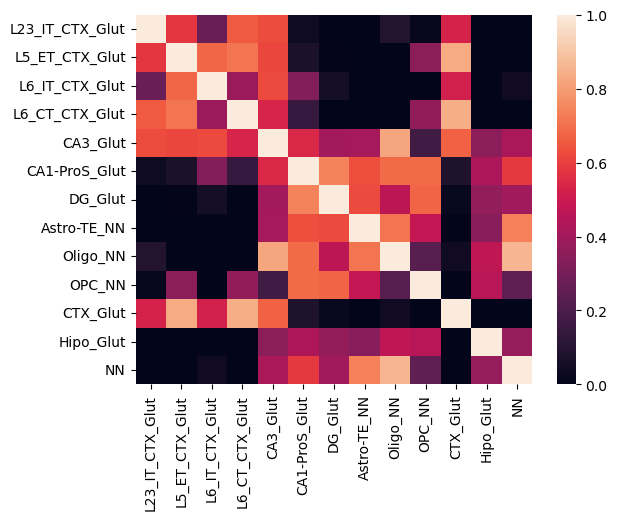

In [63]:
sns.heatmap(df_down.corr(), vmin=0, vmax=1)

In [66]:
df_mod = generate_mod_corr_matrix(cell_types, num_downsample=10)

<Axes: >

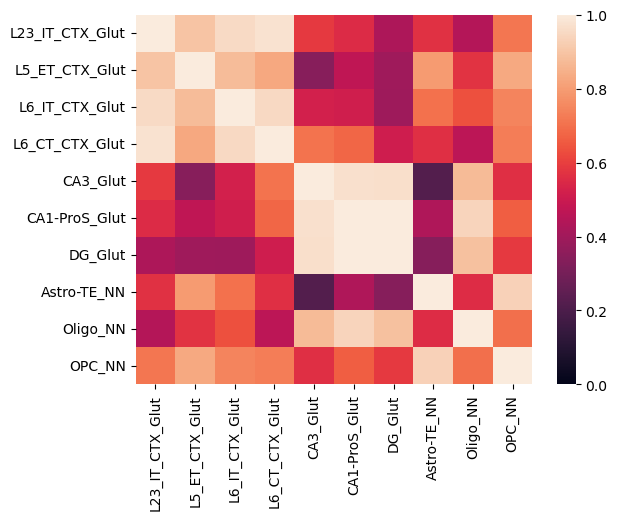

In [67]:
sns.heatmap(df_mod.corr(), vmin=0, vmax=1)

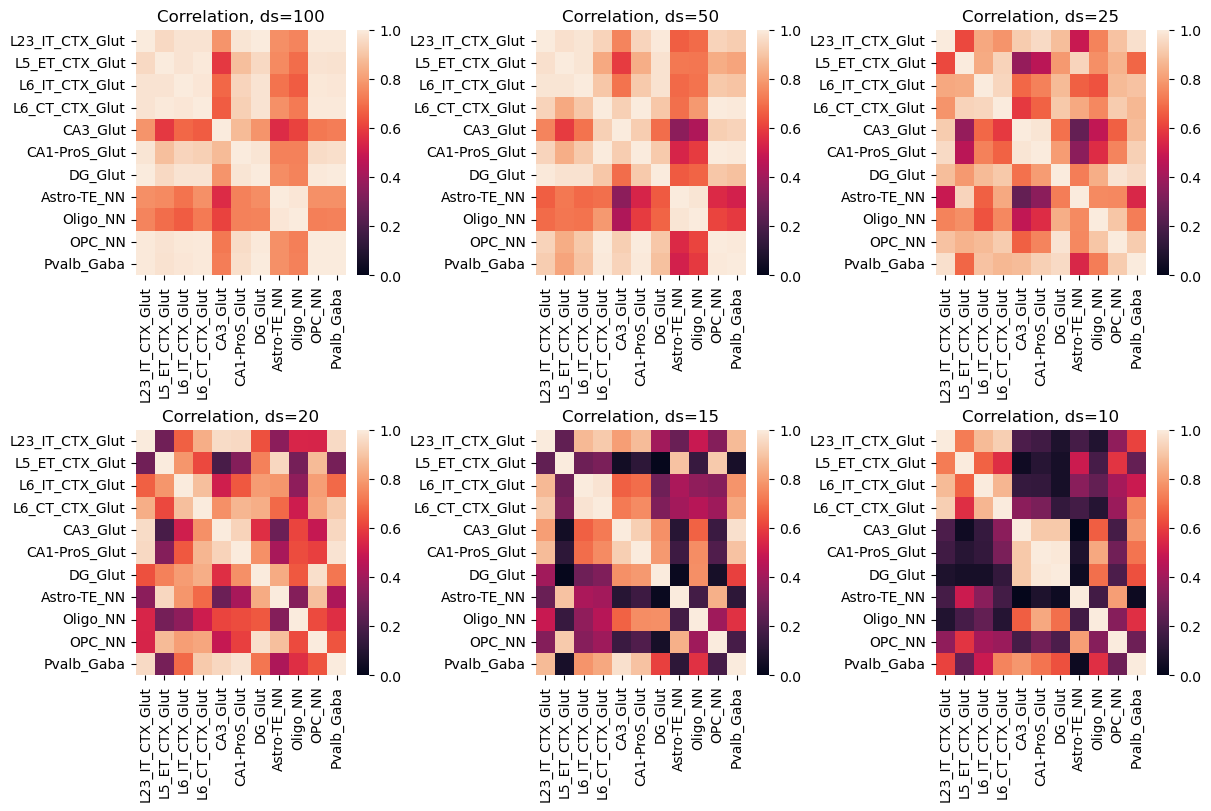

In [195]:
ds_range = [100, 50, 25, 20, 15, 10]
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
for i, ds in enumerate(ds_range): 
    df_mod = generate_mod_corr_matrix(cell_types, num_downsample=ds)
    
    tt = df_mod.corr().values
    tt = np.power(tt, 3)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes.flatten()[i])
    axes.flatten()[i].set_title(f"Correlation, ds={ds}")

plt.show()

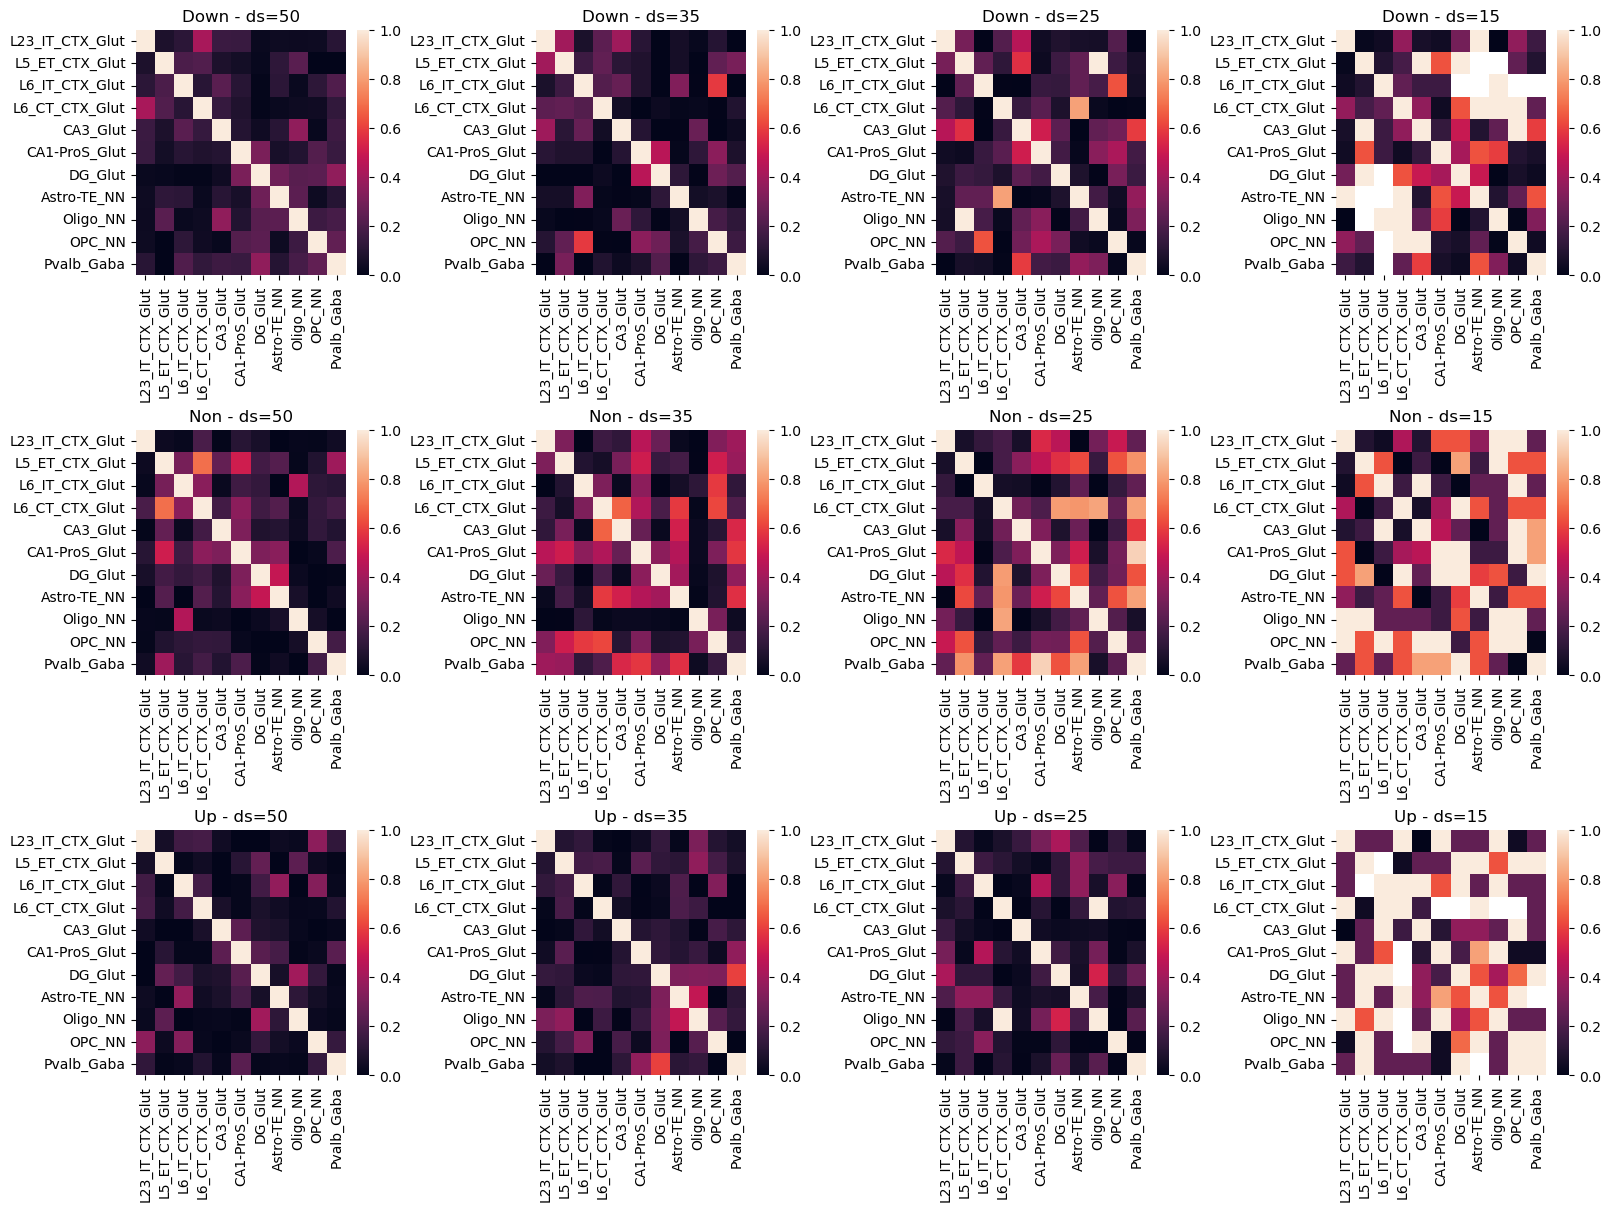

In [190]:
col = 'abs_mean_shap'
corr_method = 'pearson'

col = 'rank'
corr_method = 'spearman'

power = 2

ds_range = [50, 35, 25, 15]
fig, axes = plt.subplots(3, 4, figsize=(16, 12), constrained_layout=True)
for i, ds in enumerate(ds_range): 
    df_down, df_non, df_up = generate_rank_corr_matrix(cell_types, col=col, num_downsample=ds)
    
    tt = df_down.corr(method=corr_method).values
    tt = np.power(tt, power)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes[0][i])
    axes[0][i].set_title(f"Down - ds={ds}")
    
    tt = df_non.corr(method=corr_method).values
    tt = np.power(tt, power)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes[1][i])
    axes[1][i].set_title(f"Non - ds={ds}")
    
    tt = df_up.corr(method=corr_method).values
    tt = np.power(tt, power)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes[2][i])
    axes[2][i].set_title(f"Up - ds={ds}")

plt.show()

In [113]:
df_down, df_non, df_up = generate_rank_corr_matrix(cell_types, col=col, num_downsample=10)

In [8]:
features = df_down.index.union(df_non.index).union(df_up.index)
features

NameError: name 'df_down' is not defined